# Project Introduction: Integrating ADX and Parabolic SAR for Stock Analysis

## Objective
The objective of this project is to develop a reliable stock screening tool that identifies potential buy and sell signals using two powerful technical indicators: the Average Directional Index (ADX) and the Parabolic Stop and Reverse (SAR). By combining these indicators, we aim to enhance the accuracy of our signals, leveraging the strengths of both trend strength and trend-following analysis.

## Background
Technical analysis involves using historical price and volume data to forecast future price movements. Among the myriad of technical indicators available, ADX and SAR are two widely respected tools that traders use to assess market conditions.

## Why ADX and Parabolic SAR?

### Average Directional Index (ADX)
- **Purpose:** The ADX is used to quantify the strength of a trend, regardless of its direction. It helps traders understand whether a market is trending or ranging.
- **Components:**
  - **ADX Line:** Indicates the strength of a trend. A value above 25 typically signifies a strong trend, while a value below 20 indicates a weak or non-trending market.
  - **Plus Directional Indicator (+DI):** Measures the presence of upward trend movement.
  - **Minus Directional Indicator (-DI):** Measures the presence of downward trend movement.
- **Signals:**
  - **Strong Trend:** ADX above 25.
  - **Weak Trend:** ADX below 20.

### Parabolic Stop and Reverse (SAR)
- **Purpose:** The Parabolic SAR is a trend-following indicator that provides potential entry and exit points based on price reversals.
- **Components:**
  - **SAR Line:** A series of dots placed either above or below the price chart, indicating potential reversal points.
- **Signals:**
  - **Buy Signal:** When the price crosses above the SAR line.
  - **Sell Signal:** When the price crosses below the SAR line.

## Combining ADX and Parabolic SAR
Using these indicators together can help confirm signals and reduce false positives:

- **Enhanced Accuracy:** While the ADX helps identify the strength of a trend, SAR provides precise entry and exit points during these trends.
- **Filter for False Signals:** The SAR can sometimes give premature signals in weak trends. By requiring confirmation through ADX's trend strength, we filter out some of these false signals.

## Methodology
- **Data Collection:** We collect historical price data for a selection of stocks over a specified period.
- **Indicator Calculation:** We calculate the ADX and SAR for each stock.
- **Stock Screening:** We screen stocks based on the following criteria:
  - **Buy Criteria:** ADX above 30, indicating a strong trend, and the price crosses above the SAR line.
  - **Sell Criteria:** ADX above 30, indicating a strong trend, and the price crosses below the SAR line.
- **Visualization and Export:** We visualize the results and export the screened stocks to a CSV file for further analysis.

## Data Source and Flexibility
In this analysis, we will be using data from the FTSE 250 companies. However, feel free to use any dataset you prefer by simply changing the CSV file name in the script. Ensure that your dataset contains a column named "Ticker". 

## Conclusion
This project aims to leverage the complementary strengths of ADX and Parabolic SAR to create a thought-provoking stock screening tool. By considering both trend strength and precise entry/exit points, we can provide more potential buy and sell signals. The chosen thresholds and periods can be customized to suit your preferences and further investigations, enabling a flexible approach to stock analysis.


In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import contextlib
import sys
import os
from tqdm import tqdm

# Function to suppress print statements
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Function to calculate ADX
def calculate_adx(data, window=14):
    high = data['High']
    low = data['Low']
    close = data['Close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    tr = pd.concat([tr1, tr2, tr3], axis=1, join='inner').max(axis=1)
    
    atr = tr.rolling(window).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha=1/window).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/window).mean() / atr))
    
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (window - 1)) + dx) / window
    data['ADX'] = adx.ewm(alpha=1/window).mean()
    return data

# Function to calculate SAR
def calculate_sar(data, acceleration=0.02, maximum=0.2):
    high = data['High']
    low = data['Low']
    close = data['Close']
    
    sar = close.copy()
    long = True
    af = acceleration
    ep = low.iloc[0]
    sar.iloc[0] = ep
    
    for i in range(1, len(sar)):
        if long:
            ep = max(high.iloc[i], ep)
        else:
            ep = min(low.iloc[i], ep)
        
        sar.iloc[i] = sar.iloc[i-1] + af * (ep - sar.iloc[i-1])
        
        reverse = False
        if long:
            if low.iloc[i] < sar.iloc[i]:
                long = False
                reverse = True
                sar.iloc[i] = ep
                ep = low.iloc[i]
                af = acceleration
        else:
            if high.iloc[i] > sar.iloc[i]:
                long = True
                reverse = True
                sar.iloc[i] = ep
                ep = high.iloc[i]
                af = acceleration
        
        if not reverse:
            if long:
                if high.iloc[i] > ep:
                    ep = high.iloc[i]
                    af = min(af + acceleration, maximum)
            else:
                if low.iloc[i] < ep:
                    ep = low.iloc[i]
                    af = min(af + acceleration, maximum)
    
    data['SAR'] = sar
    return data

# Function to analyze stock for ADX and SAR
def analyze_stock_adx_sar(symbol):
    try:
        
        end_date = datetime.now() - timedelta(days=1)
        start_date = end_date - timedelta(days=9*30)  

        # Suppress yfinance output
        with suppress_output():
            data = yf.download(symbol, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        
        if data.empty:
            print(f"No data fetched for {symbol}")
            return None

        # Calculate ADX and SAR
        data = calculate_adx(data)
        data = calculate_sar(data)

        data.dropna(subset=['ADX', 'SAR'], inplace=True)

        if data.empty:
            print(f"Insufficient data after calculating indicators for {symbol}")
            return None

        # Determine if the stock meets any of the criteria
        latest_adx = data['ADX'].iloc[-1]
        latest_close = data['Close'].iloc[-1]
        latest_sar = data['SAR'].iloc[-1]

        # Criteria: ADX > 25 indicates a strong trend
        adx_strong_trend = latest_adx > 30

        # Criteria: Close price crossing SAR
        buy_signal = adx_strong_trend and latest_close > latest_sar
        sell_signal = adx_strong_trend and latest_close < latest_sar

        # Determine if the stock meets any of the criteria
        meets_criteria = buy_signal or sell_signal

        return {
            "Symbol": symbol,
            "Data": data,
            "ADX": latest_adx,
            "Close": latest_close,
            "SAR": latest_sar,
            "ADX_Strong_Trend": adx_strong_trend,
            "Buy_Signal": buy_signal,
            "Sell_Signal": sell_signal,
            "Meets Criteria": meets_criteria
        }

    except Exception as e:
        print(f"Error analyzing stock {symbol}: {e}")
        return None

# Load tickers from the CSV file
tickers_df = pd.read_csv('ftse_250_tickers.csv')
symbols = tickers_df['Ticker'].tolist()

# Initialize list to store results

results = []

# Analyze each stock
#for symbol in symbols:
for symbol in tqdm(symbols, desc="Processing stocks"):
    stock_data = analyze_stock_adx_sar(symbol)
    if stock_data is not None and stock_data["Meets Criteria"]:  # Only include stocks meeting the criteria
        results.append(stock_data)

# Convert results to DataFrame
results_df = pd.DataFrame([{
    "Symbol": r["Symbol"],
    "ADX": r["ADX"],
    "Close": r["Close"],
    "SAR": r["SAR"],
    "ADX_Strong_Trend": r["ADX_Strong_Trend"],
    "Buy_Signal": r["Buy_Signal"],
    "Sell_Signal": r["Sell_Signal"],
    "Meets Criteria": r["Meets Criteria"]
} for r in results])

# Export results to CSV
results_df.to_csv("adx_sar_screener_results.csv", index=False)

results_df.index = np.arange(1, len(results_df) + 1)

# Print results
results_df



Processing stocks: 100%|█████████████████████████████████████████████████████████████| 247/247 [00:31<00:00,  7.87it/s]


Symbol        ADX        Close          SAR  ADX_Strong_Trend  Buy_Signal  \
1    SPT.L  36.286544   182.000000   194.977855              True       False   
2   EBOX.L  40.157911     0.667000     0.589081              True        True   
3   MOON.L  40.979445   206.500000   160.170033              True        True   
4   JLEN.L  31.097866    89.900002    86.113034              True        True   
5   DARK.L  36.250424   578.599976   621.650547              True       False   
6    FAN.L  34.017636   503.000000   441.589757              True        True   
7   FCSS.L  36.071129   195.000000   228.936769              True       False   
8    EWI.L  30.772532   155.000000   142.321265              True        True   
9   BAKK.L  33.548368   151.500000   131.087977              True        True   
10  SSPG.L  32.486653   179.199997   142.965997              True        True   
11   SDP.L  37.941819   541.000000   519.656644              True        True   
12   SCT.L  40.203353  1607.000000  1770.372335              True       False   
13   JII.L  31.053783  1030.000000   955.401499              True        True   
14   HRI.L  30.923915  2285.000000  2150.008761              True        True   
15  WTAN.L  35.131389   272.000000   257.582656              True        True   
16   SRP.L  30.645559   187.500000   168.836541              True        True   
17  SYNC.L  30.442353   123.800003   108.245775              True        True   
18  VMUK.L  39.963481   215.199997   207.305880              True        True   
19  BVIC.L  49.281431  1264.000000  1001.228221              True        True   
20   ASL.L  36.226722  1614.000000  1477.627818              True        True   
21   PIN.L  31.662147   312.000000   323.006032              True       False   
22    HL.L  36.484221  1094.000000   968.034446              True        True   
23   JFJ.L  32.092474   558.000000   517.076806              True        True   
24   VTY.L  31.902842  1327.000000  1186.331570              True        True   
25  INDV.L  36.093658   783.000000  1351.017056              True       False   
26  CRST.L  30.108728   257.200012   224.781441              True        True   
27  BHMG.L  33.684792   375.500000   353.071678              True        True   
28   FSG.L  32.154390   510.000000   449.266782              True        True   
29  PRTC.L  45.389863   172.600006   219.928045              True       False   

    Sell_Signal  Meets Criteria  
1          True            True  
2         False            True  
3         False            True  
4         False            True  
5          True            True  
6         False            True  
7          True            True  
8         False            True  
9         False            True  
10        False            True  
11        False            True  
12         True            True  
13        False            True  
14        False            True  
15        False            True  
16        False            True  
17        False            True  
18        False            True  
19        False            True  
20        False            True  
21         True            True  
22        False            True  
23        False            True  
24        False            True  
25         True            True  
26        False            True  
27        False            True  
28        False            True  
29         True            True

In [5]:
# Calculate and print the detailed results
total_tickers = len(tickers_df)
tickers_meeting_criteria = len(results_df)
percentage_meeting_criteria = (tickers_meeting_criteria / total_tickers) * 100

# Print results
print("My preference is a 5-20% threshold which strikes a balance, ensuring a\nfocused yet diverse selection of stocks to allow further investigations.")
print(f"Tickers meeting criteria: {tickers_meeting_criteria}")
print(f"Percentage of shares that pass the criteria: {percentage_meeting_criteria:.2f}%")

# Determine if the percentage is within the desired filter range
if 5 <= percentage_meeting_criteria <= 20:
    print("The percentage of shares meeting the criteria is within the desirable range (5-20%).")
else:
    print("The percentage of shares meeting the criteria is outside the desirable range (5-15%).")




My preference is a 5-20% threshold which strikes a balance, ensuring a
focused yet diverse selection of stocks to allow further investigations.
Tickers meeting criteria: 29
Percentage of shares that pass the criteria: 11.74%
The percentage of shares meeting the criteria is within the desirable range (5-20%).


The following stocks have met the specified criteria. A plot is displayed showing the stock price and its relationship to the associated indicators. Additionally, detailed financial and company information is provided for each stock.



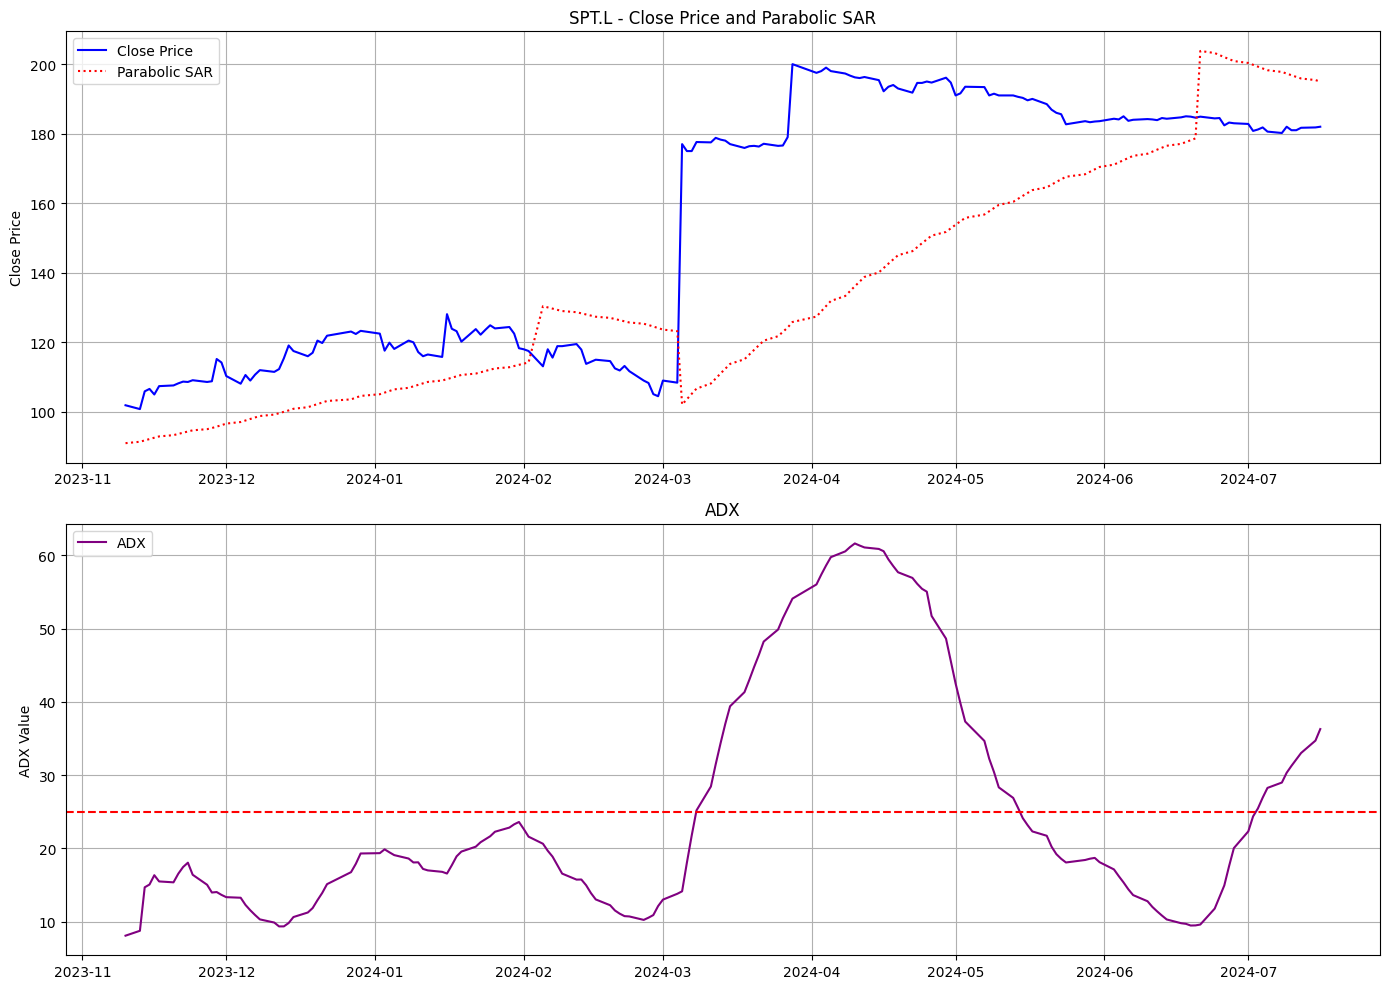

Ticker:                   SPT.L
Company:                  SPIRENT COMMUNICATIONS PLC ORD 
Sector:                   Technology
Industry:                 Software - Infrastructure
Market Cap:               £1,040,187,904
Shares Outstanding:       571,846,016
52-Week High:             203.796
52-Week Low:              79.75
PE Ratio (TTM):           60.63333
EPS (TTM):                0.03
Dividend Yield:           0.0344
Payout Ratio:             1.8363
Revenue (TTM):            £474,300,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £25,200,000
Total Debt:               £21,400,000
Operating Cash Flow (TTM): £31,900,000
Free Cash Flow (TTM):     £23,587,500

Description:              Spirent Communications plc provides automated test and assurance solutions in the Americas, the Asia Pacific, Europe, the Middle East, and Africa. The company operates through Lifecycle Service Assurance, and Networks & Security segments. The Lifecycle Service Assurance segment offers lab-based

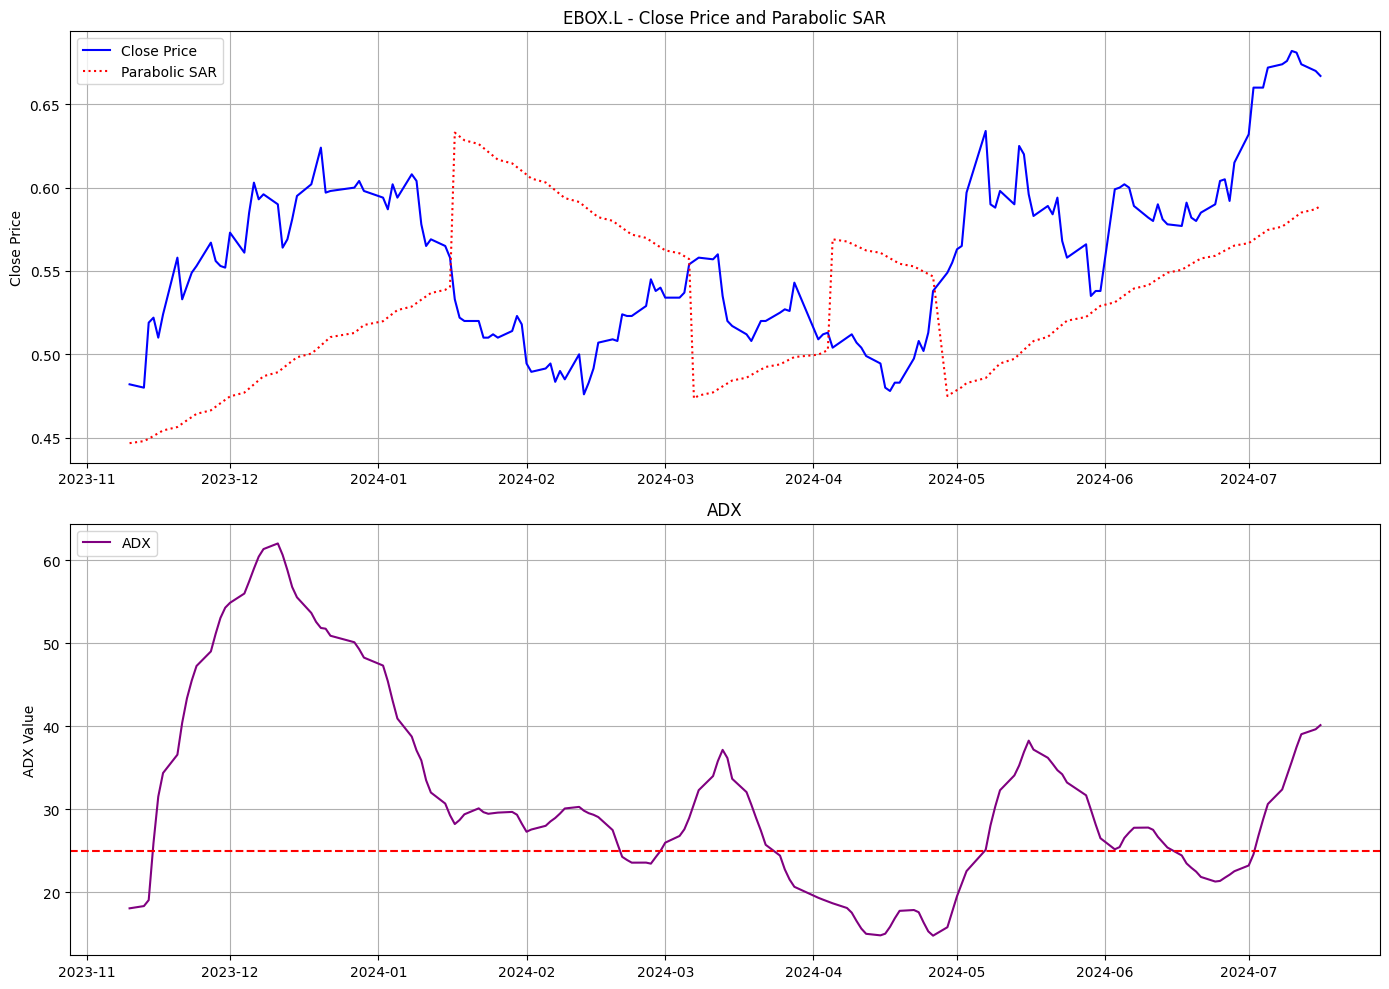

Ticker:                   EBOX.L
Company:                  TRITAX EUROBOX PLC ORD EUR0.01 
Sector:                   N/A
Industry:                 N/A
Market Cap:               £281,958,880
Shares Outstanding:       N/A
52-Week High:             67.1
52-Week Low:              0.4355
PE Ratio (TTM):           2.6363637
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


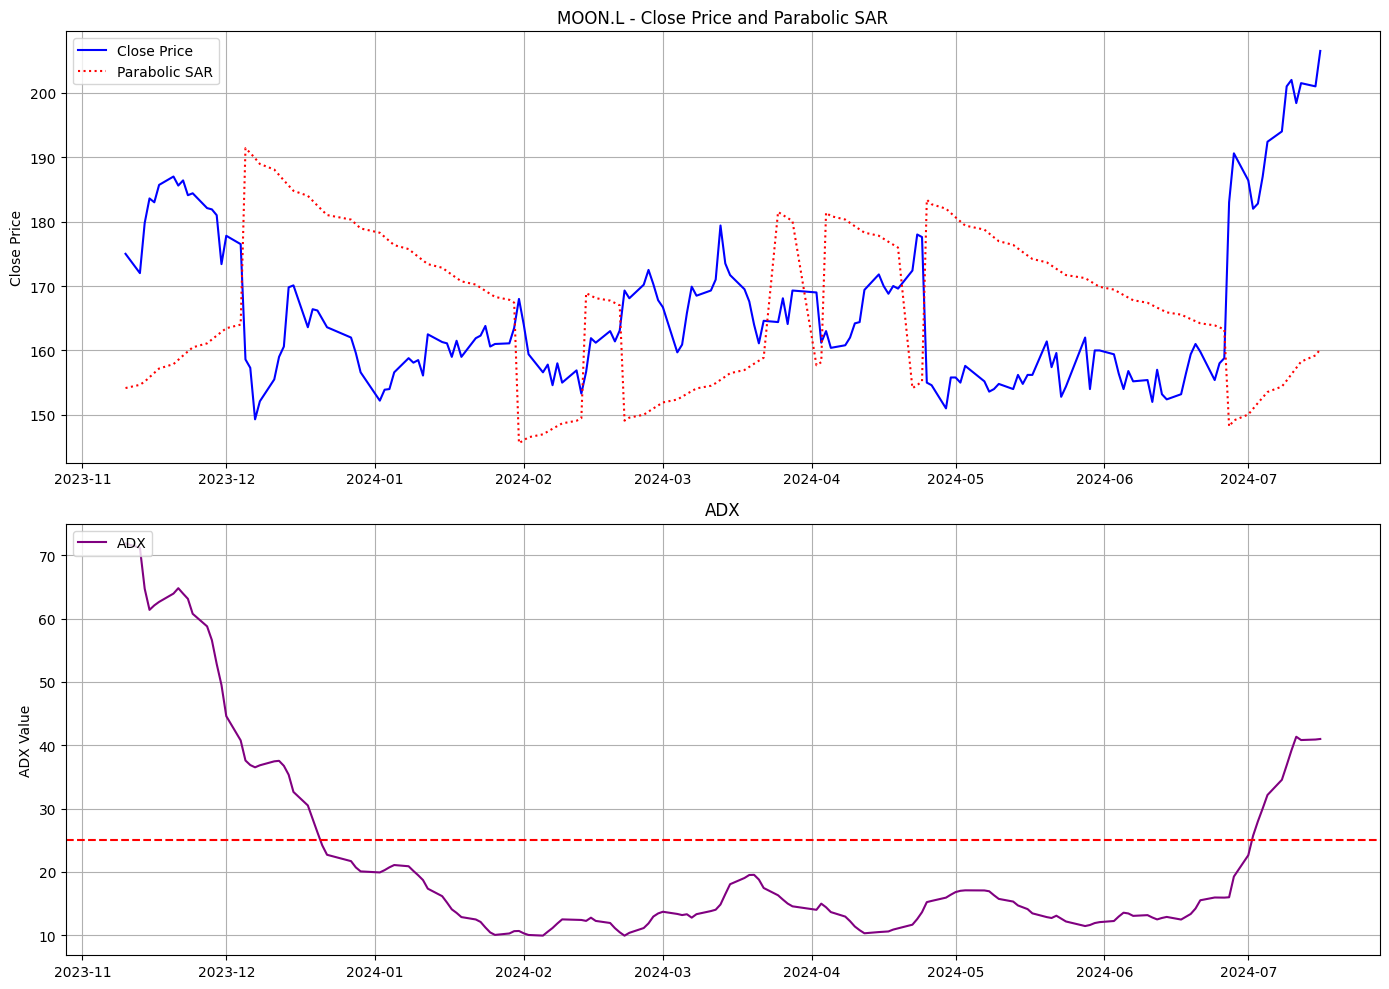

Ticker:                   MOON.L
Company:                  MOONPIG GROUP PLC ORD 10P
Sector:                   Consumer Cyclical
Industry:                 Specialty Retail
Market Cap:               £703,428,672
Shares Outstanding:       344,817,984
52-Week High:             207.0
52-Week Low:              145.6
PE Ratio (TTM):           20.4
EPS (TTM):                0.1
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £341,140,992
Gross Profit (TTM):       N/A
Net Income (TTM):         £34,169,000
Total Debt:               £134,694,000
Operating Cash Flow (TTM): £74,575,000
Free Cash Flow (TTM):     £48,295,752

Description:              Moonpig Group PLC, together with its subsidiaries, provides online greeting cards and gifts in the Netherlands and the United Kingdom. The company sells its products under the Moonpig, Buyagift, Red Letter Days, and Greetz brands through website and mobile app. It also engages in trading activities, as well as offe

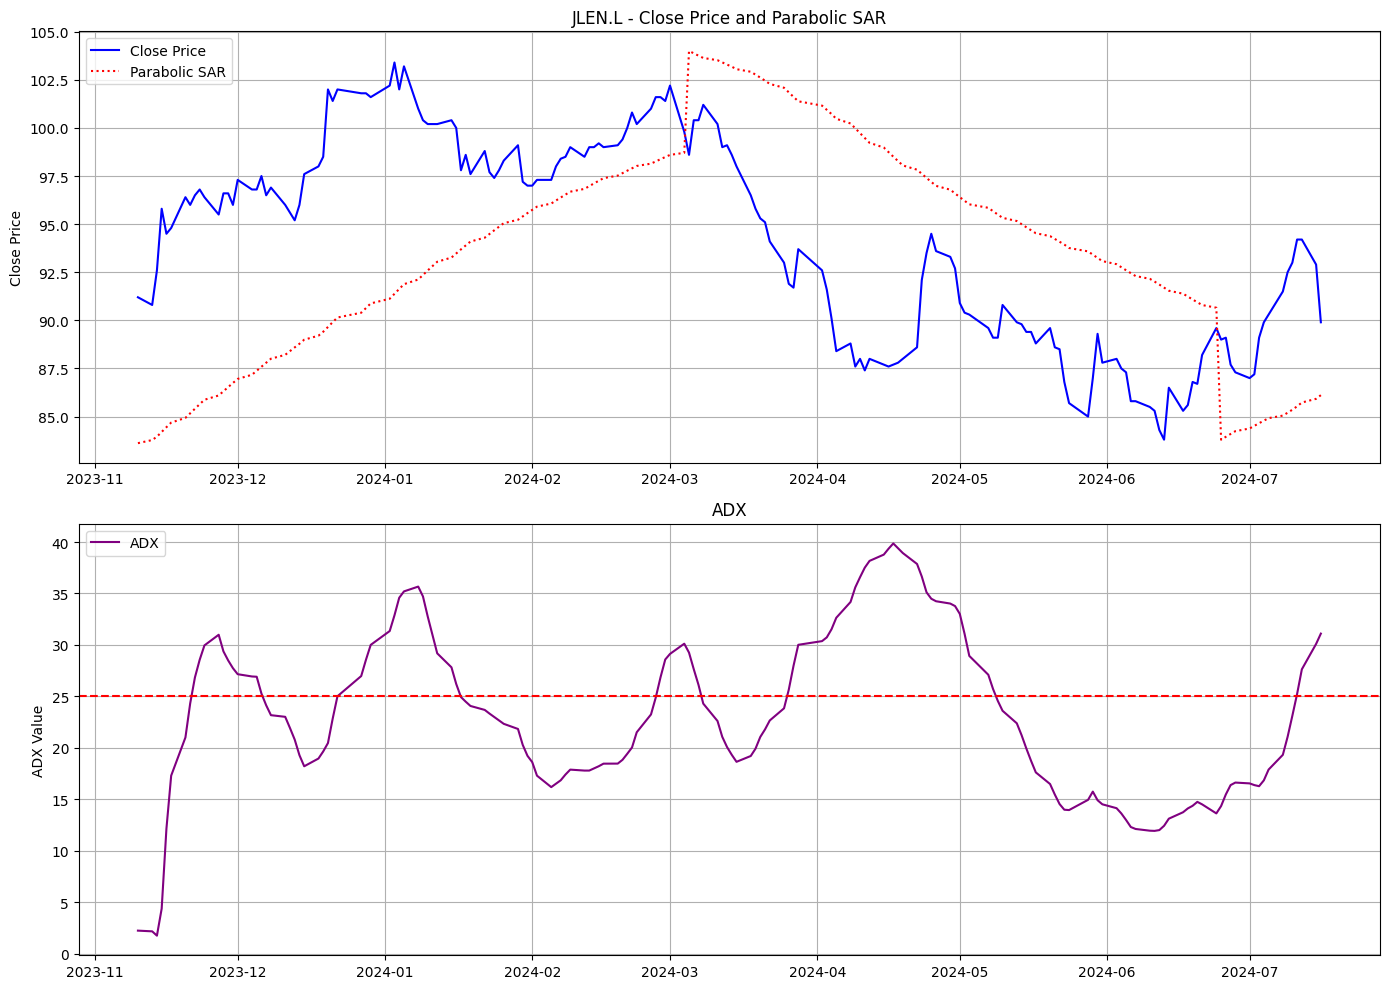

Ticker:                   JLEN.L
Company:                  JLEN ENVIRONMENTAL ASSETS GROUP
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £602,654,720
Shares Outstanding:       661,531,008
52-Week High:             117.81
52-Week Low:              83.46
PE Ratio (TTM):           N/A
EPS (TTM):                -0.02
Dividend Yield:           0.084
Payout Ratio:             4.5313
Revenue (TTM):            £-3,827,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £-13,937,000
Total Debt:               £0
Operating Cash Flow (TTM): £-9,856,000
Free Cash Flow (TTM):     £-8,456,625

Description:              John Laing Environmental Assets Group Limited is a fund of John Laing Capital Management Limited.
--------------------------------------------------


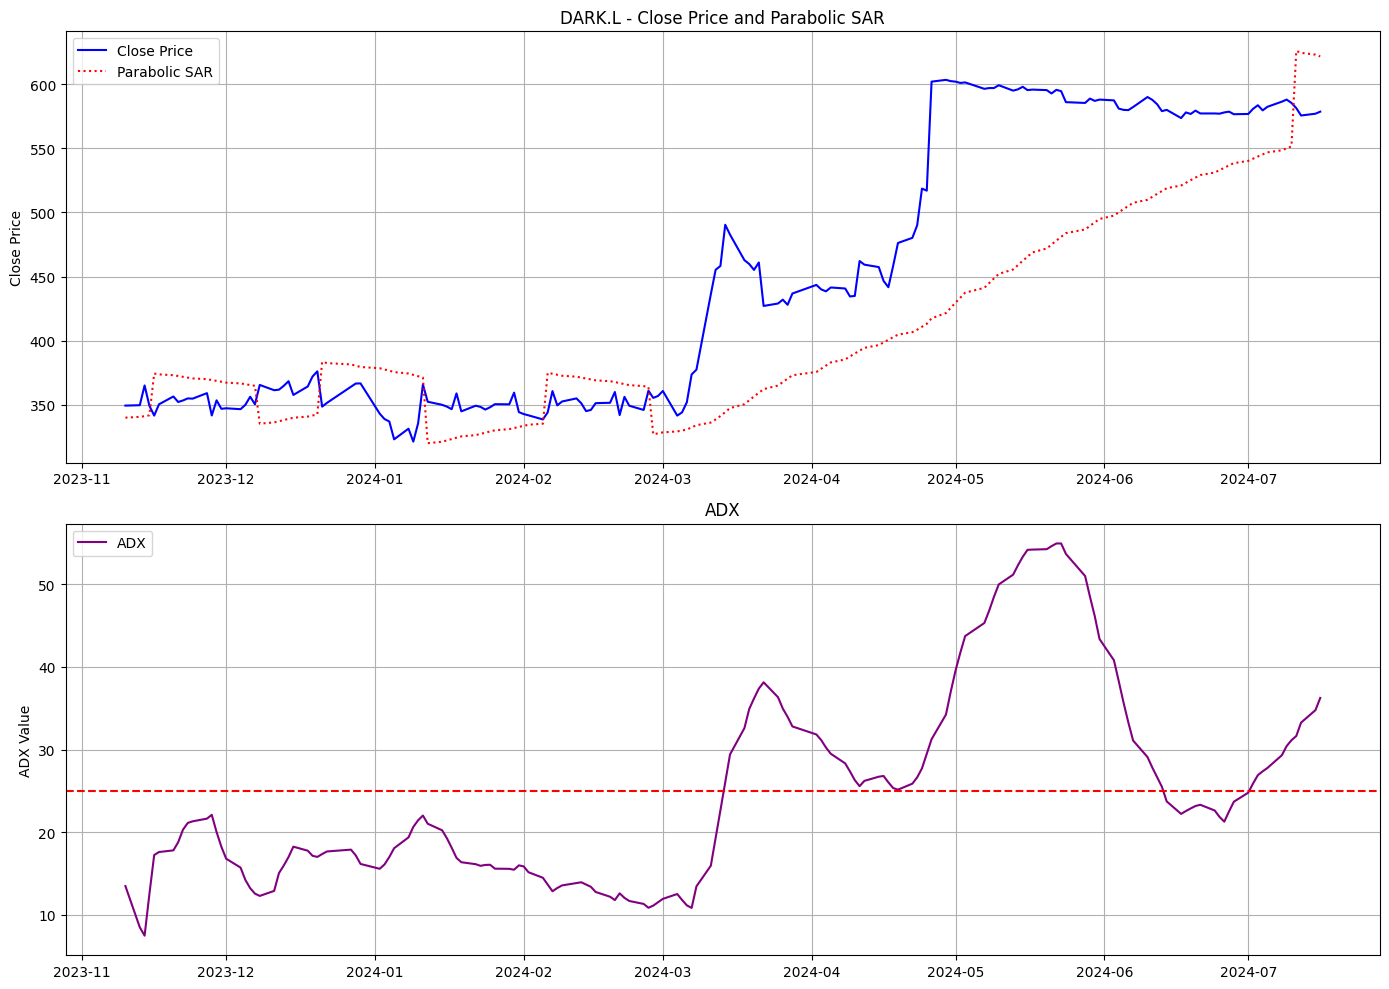

Ticker:                   DARK.L
Company:                  DARKTRACE PLC ORD GBP0.01
Sector:                   Technology
Industry:                 Software - Infrastructure
Market Cap:               £4,080,506,880
Shares Outstanding:       700,396,032
52-Week High:             625.94
52-Week Low:              320.1
PE Ratio (TTM):           44.815384
EPS (TTM):                0.13
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £616,473,984
Gross Profit (TTM):       N/A
Net Income (TTM):         £110,895,000
Total Debt:               £60,151,000
Operating Cash Flow (TTM): £172,542,000
Free Cash Flow (TTM):     £174,380,128

Description:              Darktrace plc, together with its subsidiaries, engages in the development and sale of cyber-threat defense technology solutions in the United Kingdom, the United States, Europe, and internationally. Its products include Darktrace PREVENT, an attack surface management that continuously monitors attack s

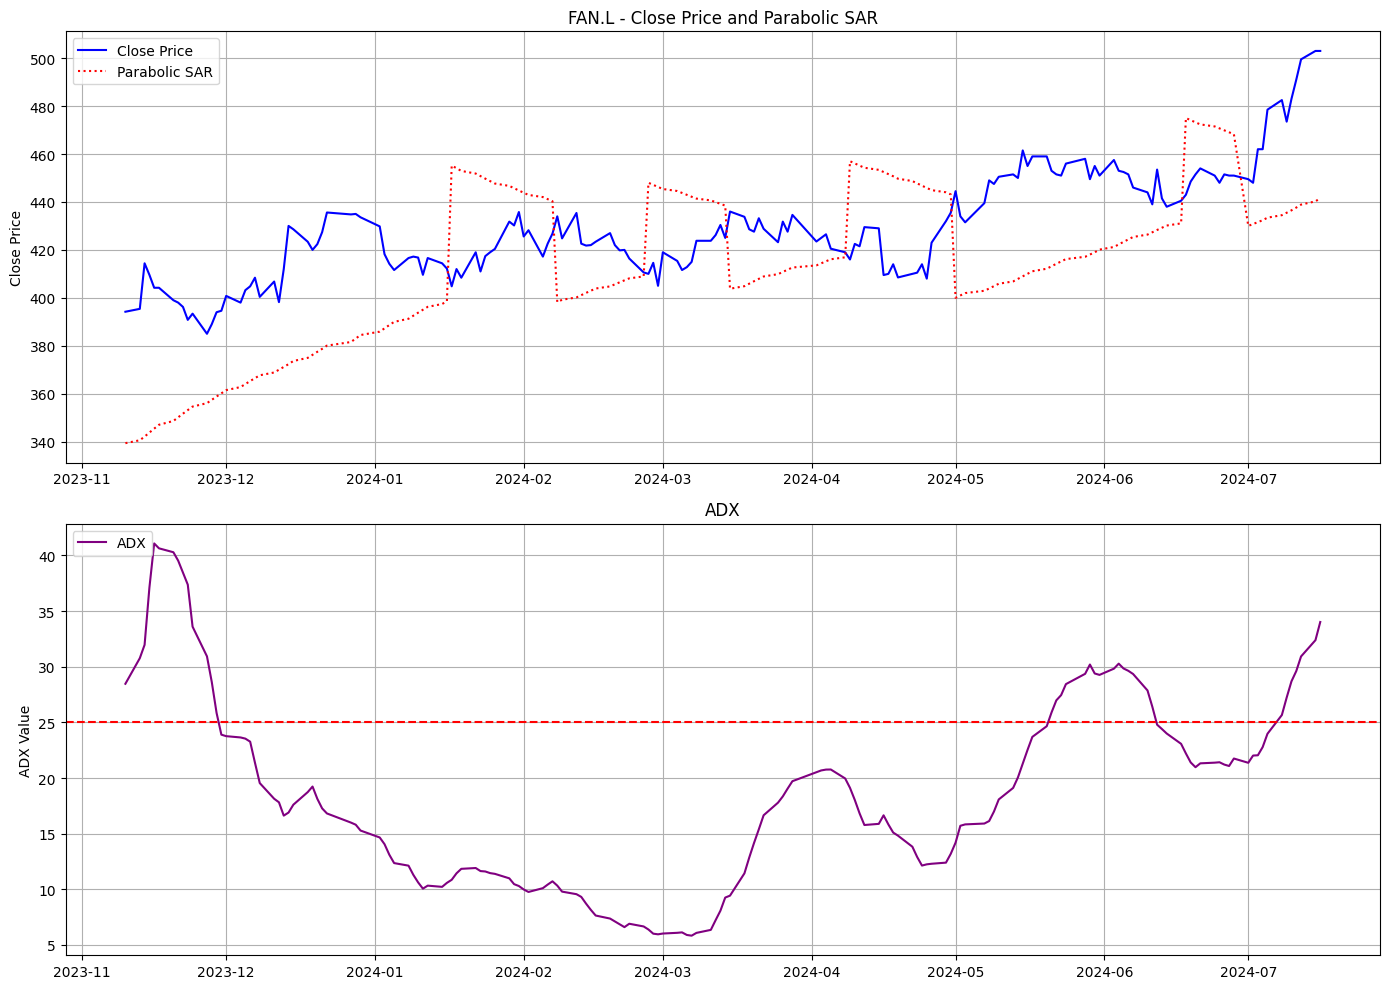

Ticker:                   FAN.L
Company:                  VOLUTION GROUP PLC ORD GBP0.01
Sector:                   Industrials
Industry:                 Building Products & Equipment
Market Cap:               £991,223,488
Shares Outstanding:       197,848,992
52-Week High:             507.0
52-Week Low:              330.0
PE Ratio (TTM):           23.857145
EPS (TTM):                0.21
Dividend Yield:           0.0167
Payout Ratio:             0.3774
Revenue (TTM):            £338,200,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £42,418,000
Total Debt:               £111,337,000
Operating Cash Flow (TTM): £75,361,000
Free Cash Flow (TTM):     £54,593,500

Description:              Volution Group plc, together with its subsidiaries, manufactures and supplies ventilation products to residential and commercial constructions in the United Kingdom, Continental Europe, and Australasia. The company offers unitary extractor fans for use in bathrooms and kitchens; mechanical an

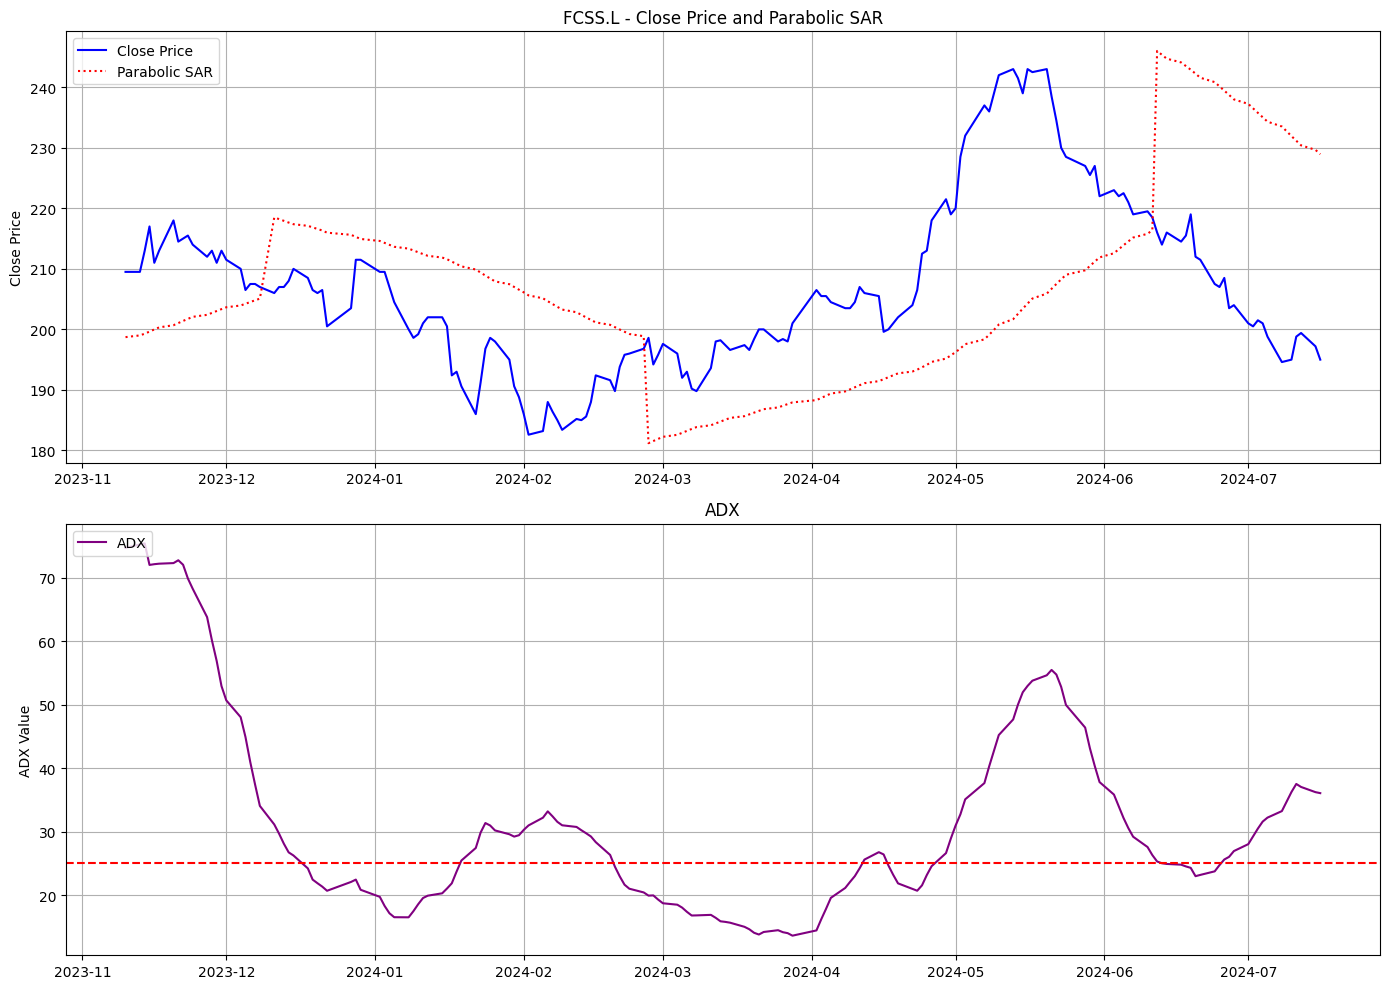

Ticker:                   FCSS.L
Company:                  FIDELITY CHINA SPECIAL SITUATIO
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,008,339,840
Shares Outstanding:       N/A
52-Week High:             246.0
52-Week Low:              181.2
PE Ratio (TTM):           N/A
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


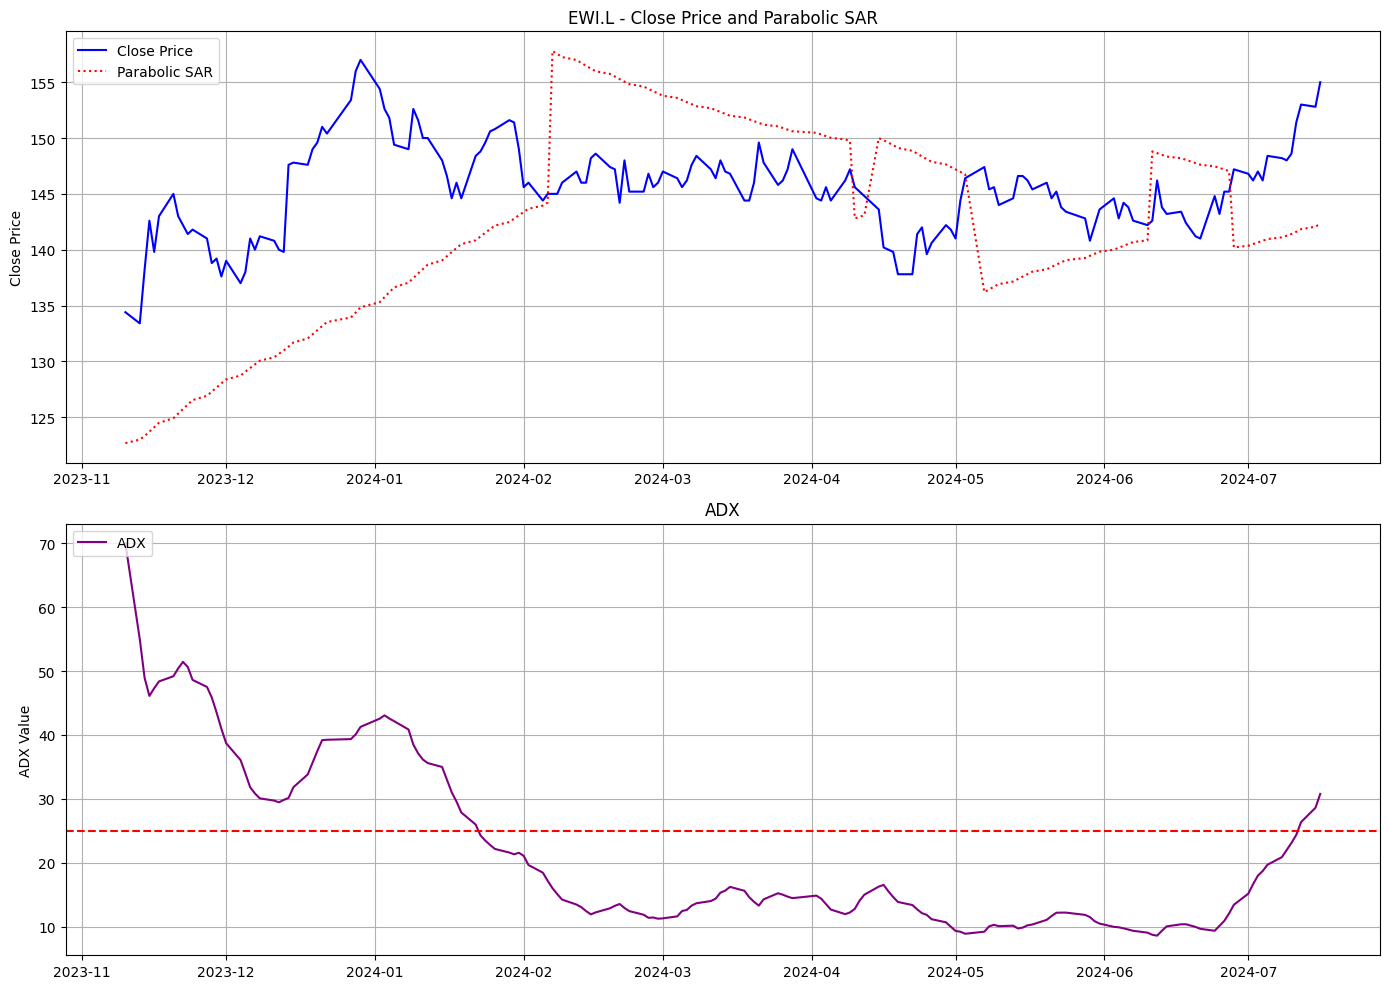

Ticker:                   EWI.L
Company:                  EDINBURGH WORLDWIDE INVESTMENT 
Sector:                   N/A
Industry:                 N/A
Market Cap:               £593,663,936
Shares Outstanding:       N/A
52-Week High:             181.11
52-Week Low:              120.8
PE Ratio (TTM):           N/A
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


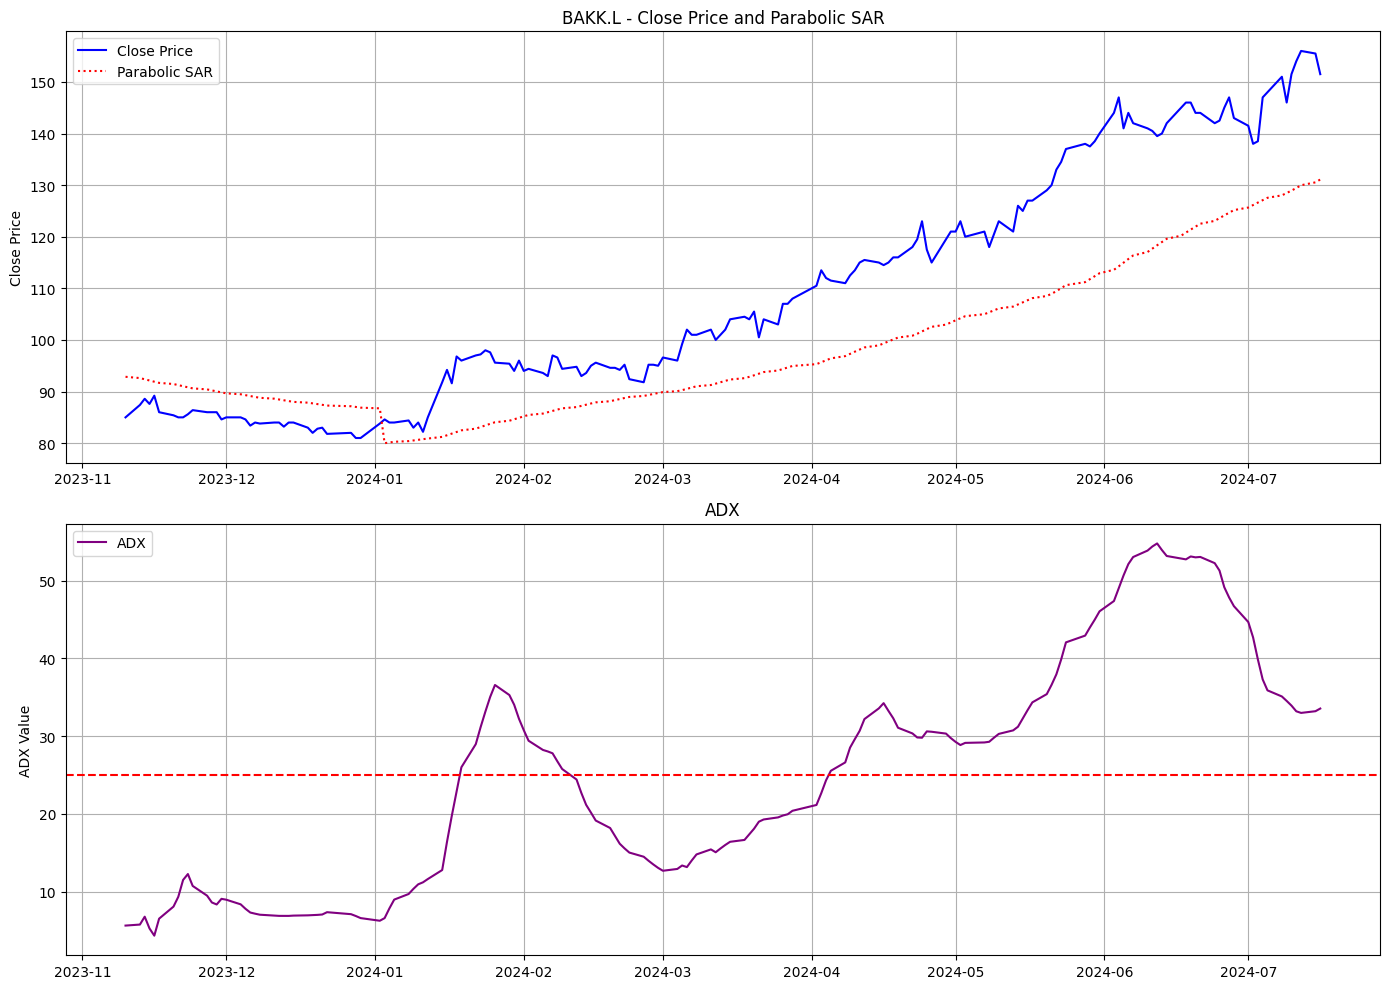

Ticker:                   BAKK.L
Company:                  BAKKAVOR GROUP PLC ORD 2P
Sector:                   Consumer Defensive
Industry:                 Packaged Foods
Market Cap:               £885,281,280
Shares Outstanding:       574,857,984
52-Week High:             158.0
52-Week Low:              80.0
PE Ratio (TTM):           17.11111
EPS (TTM):                0.09
Dividend Yield:           0.047399998
Payout Ratio:             0.7685
Revenue (TTM):            £2,203,800,064
Gross Profit (TTM):       N/A
Net Income (TTM):         £53,900,000
Total Debt:               £356,600,000
Operating Cash Flow (TTM): £147,700,000
Free Cash Flow (TTM):     £89,312,496

Description:              Bakkavor Group plc, together with its subsidiaries, engages in the preparation and marketing of fresh prepared foods in the United Kingdom, the United States, and China. It offers meals, pizzas and breads, desserts, dips, salads, soups, sauces, fresh cut salads, burritos, food-to-go products, sandw

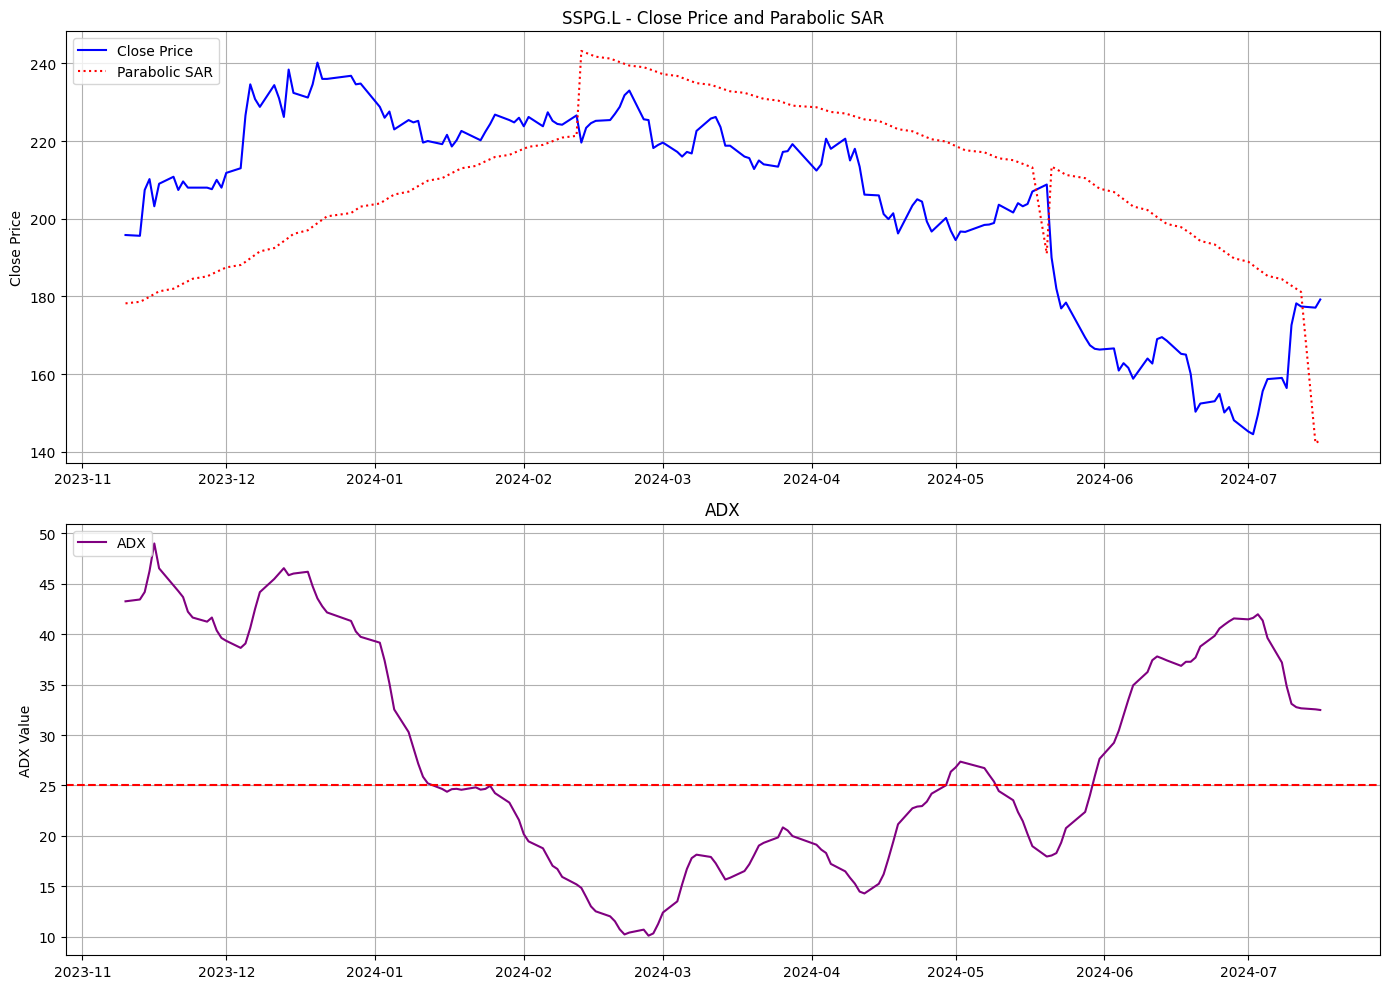

Ticker:                   SSPG.L
Company:                  SSP GROUP PLC ORD 1 17/200P
Sector:                   Consumer Cyclical
Industry:                 Restaurants
Market Cap:               £1,450,737,664
Shares Outstanding:       798,494,976
52-Week High:             267.0
52-Week Low:              142.2
PE Ratio (TTM):           181.684
EPS (TTM):                0.01
Dividend Yield:           0.013200001
Payout Ratio:             2.5
Revenue (TTM):            £3,208,499,968
Gross Profit (TTM):       N/A
Net Income (TTM):         £7,600,000
Total Debt:               £1,823,299,968
Operating Cash Flow (TTM): £485,800,000
Free Cash Flow (TTM):     £99,137,504

Description:              SSP Group plc operates food and beverage outlets in North America, Europe, the United Kingdom, Ireland, the Asia Pacific, Eastern Europe, the Middle East, and internationally. The company operates outlets at airports, railway stations, motorway service areas, hospitals, and shopping centers. It also 

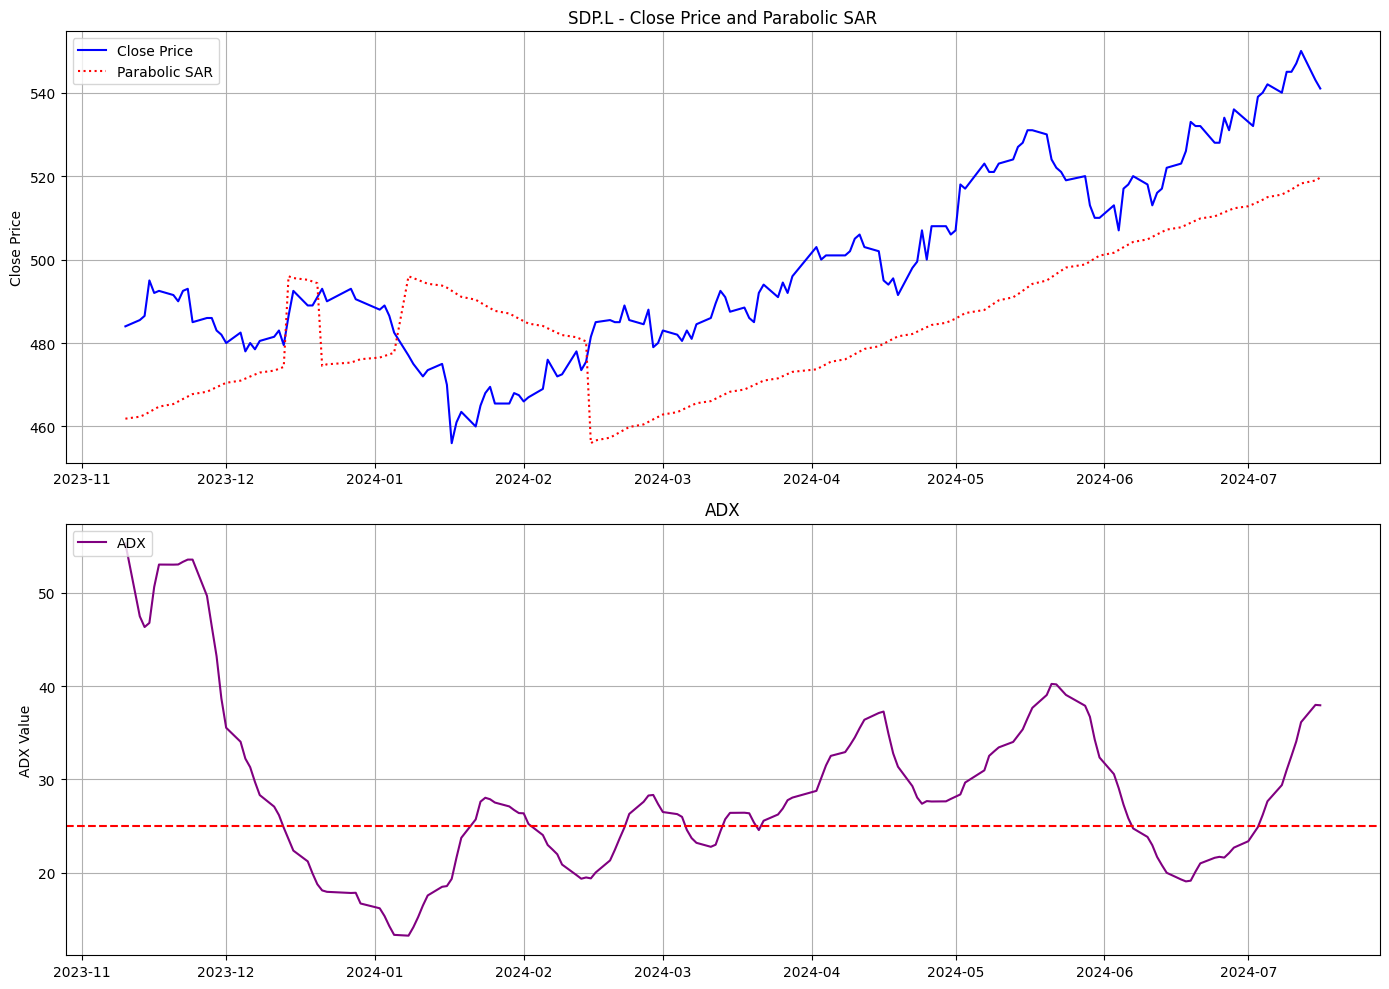

Ticker:                   SDP.L
Company:                  SCHRODER ASIAPACIFIC FUND PLC O
Sector:                   N/A
Industry:                 N/A
Market Cap:               £799,725,888
Shares Outstanding:       N/A
52-Week High:             600.19
52-Week Low:              456.0
PE Ratio (TTM):           539.37506
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


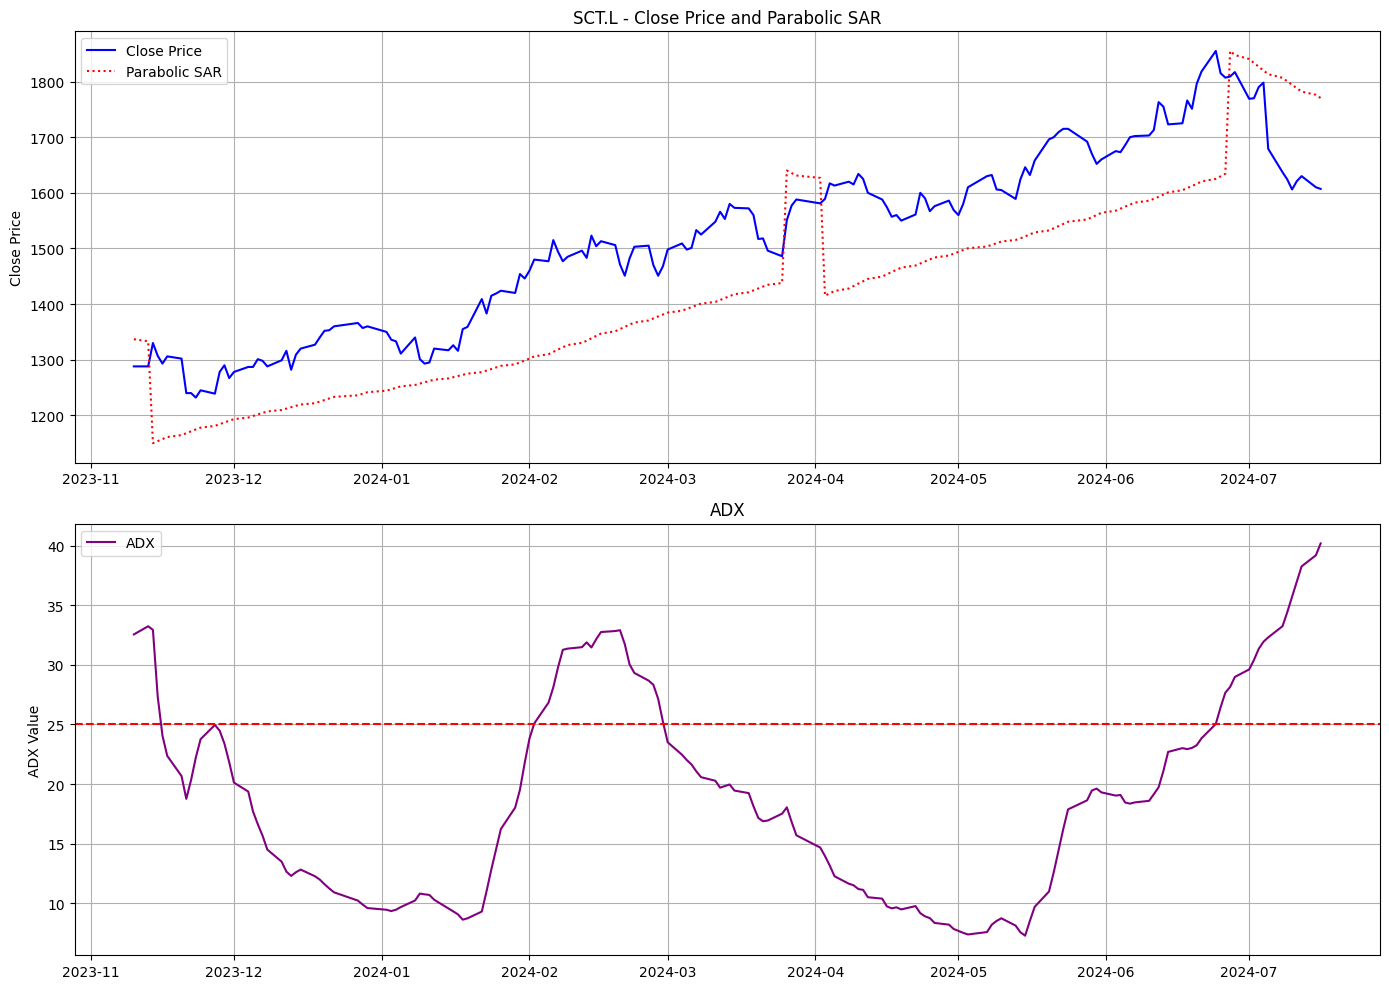

Ticker:                   SCT.L
Company:                  SOFTCAT PLC
Sector:                   Technology
Industry:                 Information Technology Services
Market Cap:               £3,144,159,488
Shares Outstanding:       199,756,000
52-Week High:             1855.0
52-Week Low:              1150.0
PE Ratio (TTM):           27.614035
EPS (TTM):                0.57
Dividend Yield:           0.0162
Payout Ratio:             0.4425
Revenue (TTM):            £940,046,976
Gross Profit (TTM):       N/A
Net Income (TTM):         £113,233,000
Total Debt:               £8,776,000
Operating Cash Flow (TTM): £94,882,000
Free Cash Flow (TTM):     £67,263,376

Description:              Softcat plc operates as a value-added IT reseller and IT infrastructure solutions provider in the United Kingdom. The company advices, procures, designs, implements, and manages technology, such as software licensing, workplace technology, networking, security, and cloud and datacenter for businesses and pu

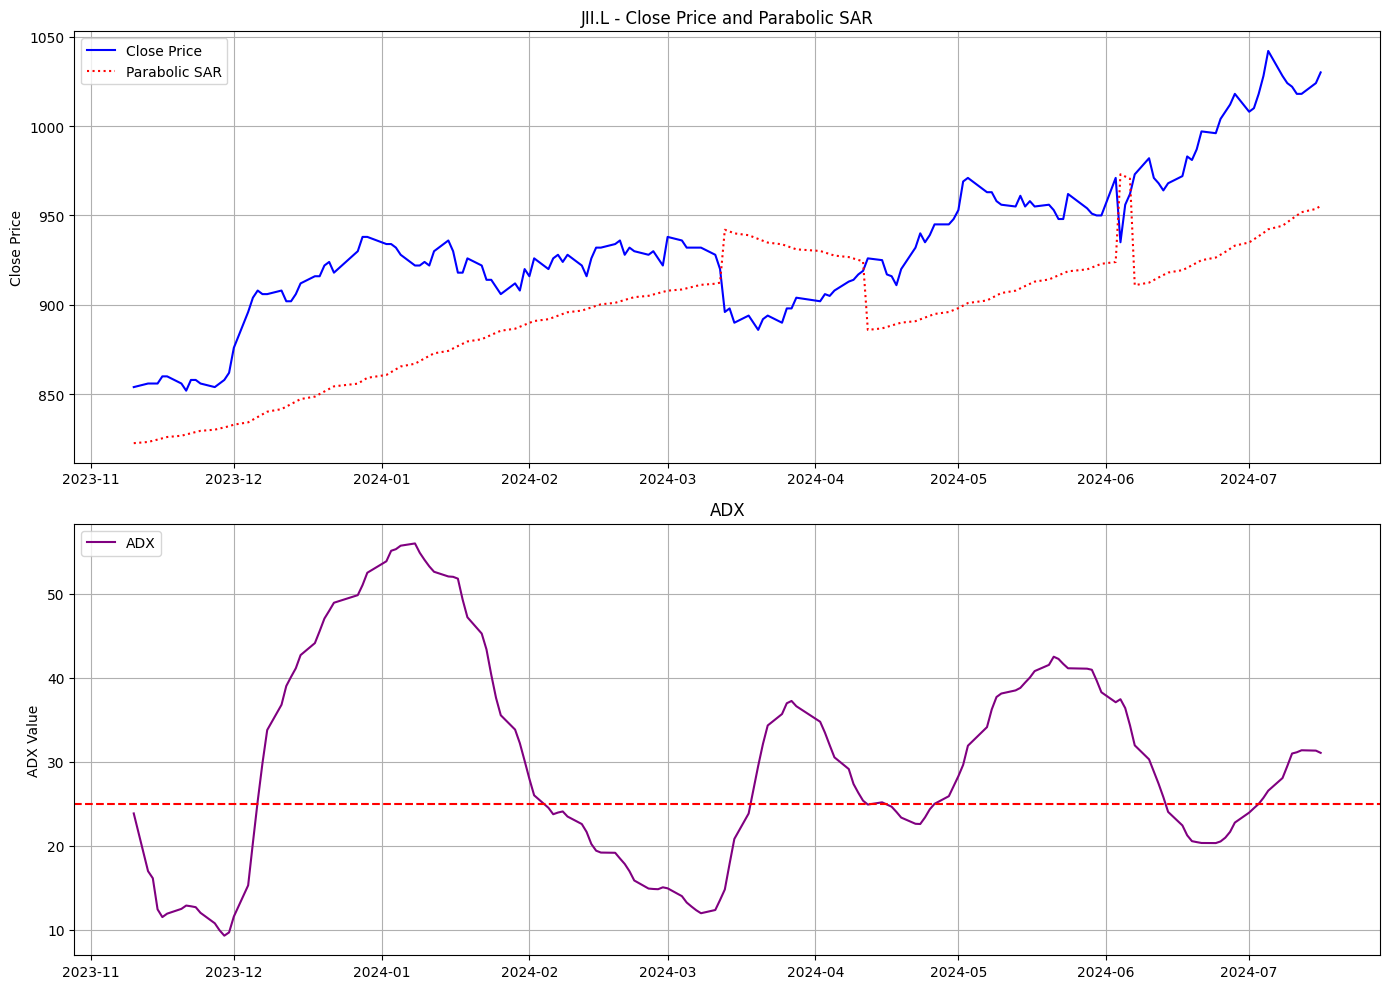

Ticker:                   JII.L
Company:                  JPMORGAN INDIAN INVESTMENT TRUS
Sector:                   N/A
Industry:                 N/A
Market Cap:               £713,978,112
Shares Outstanding:       N/A
52-Week High:             1218.41
52-Week Low:              820.0
PE Ratio (TTM):           6.636286
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


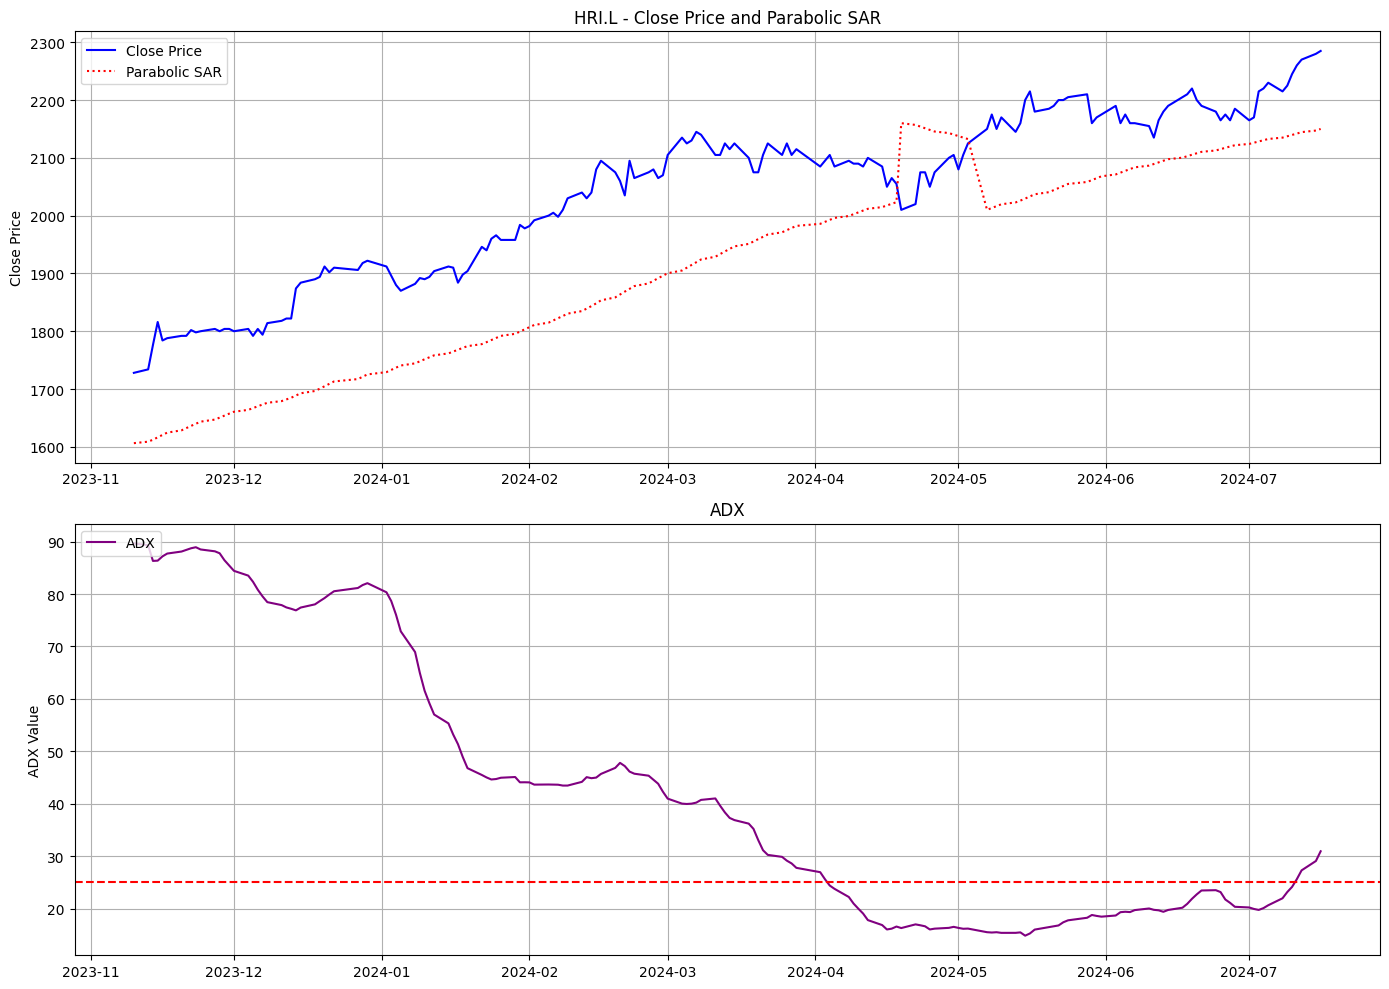

Ticker:                   HRI.L
Company:                  HERALD INVESTMENT TRUST PLC ORD
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,216,219,776
Shares Outstanding:       N/A
52-Week High:             2470.64
52-Week Low:              1590.0
PE Ratio (TTM):           27.82963
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


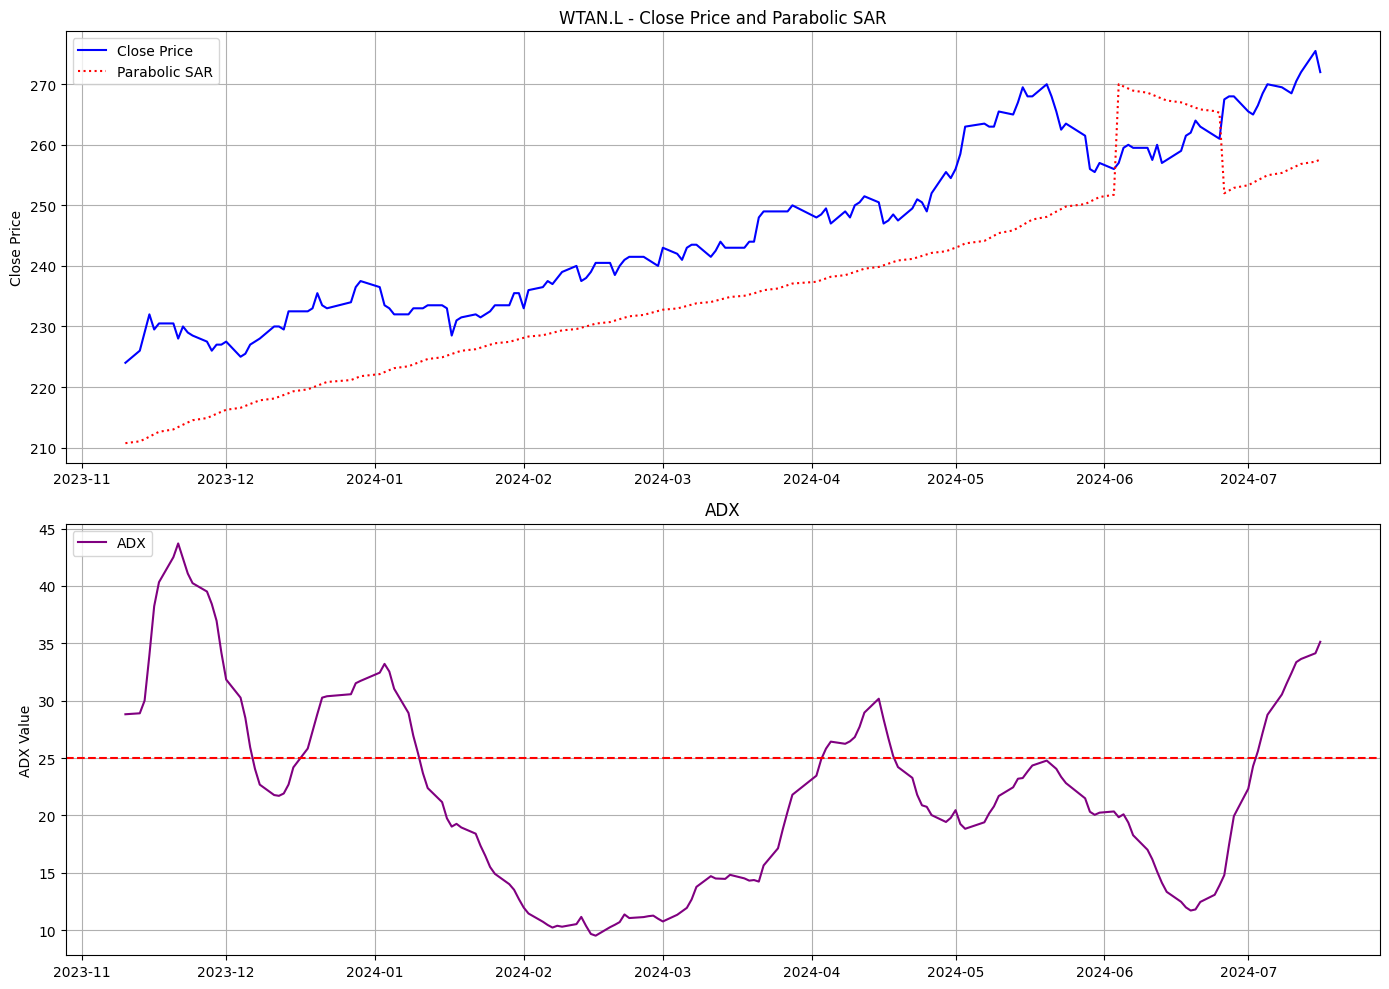

Ticker:                   WTAN.L
Company:                  WITAN INVESTMENT TRUST PLC ORD 
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,624,324,480
Shares Outstanding:       N/A
52-Week High:             275.5
52-Week Low:              209.0
PE Ratio (TTM):           9.680054
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


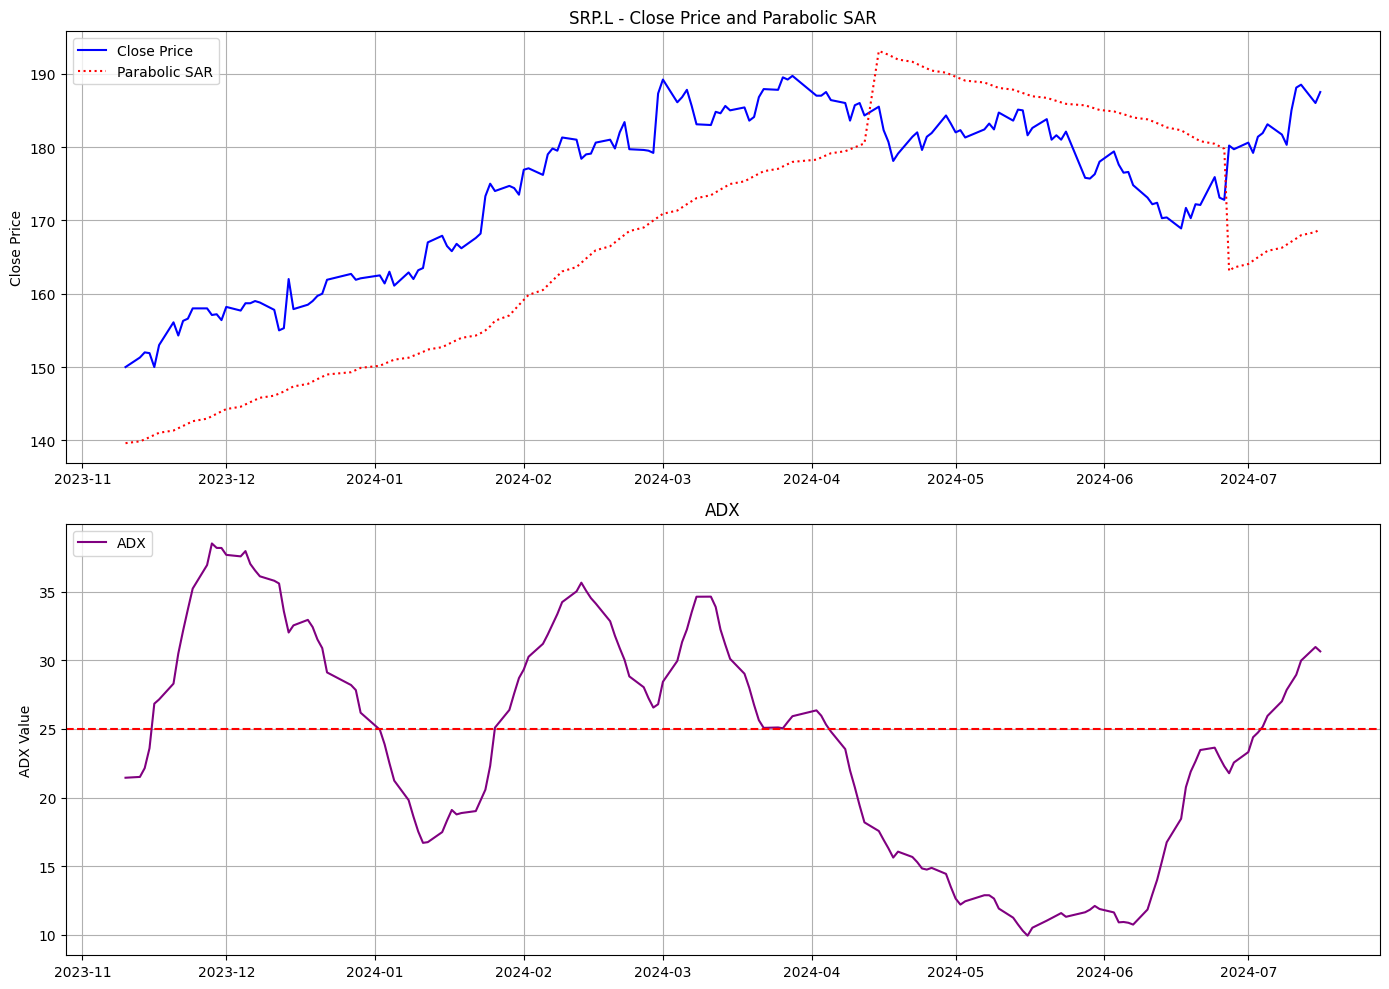

Ticker:                   SRP.L
Company:                  SERCO GROUP PLC ORD 2P
Sector:                   Industrials
Industry:                 Specialty Business Services
Market Cap:               £1,992,110,848
Shares Outstanding:       1,058,259,968
52-Week High:             193.1
52-Week Low:              138.0
PE Ratio (TTM):           10.458
EPS (TTM):                0.18
Dividend Yield:           0.0183
Payout Ratio:             0.1707
Revenue (TTM):            £4,873,800,192
Gross Profit (TTM):       N/A
Net Income (TTM):         £202,400,000
Total Debt:               £659,900,032
Operating Cash Flow (TTM): £393,100,000
Free Cash Flow (TTM):     £203,262,496

Description:              Serco Group plc provides public services in the United Kingdom, Europe, North America, the Asia Pacific, and the Middle East. It offers service design and advisory, resourcing, programmes management, systems integration, case management, engineering, and assets and facilities management services.

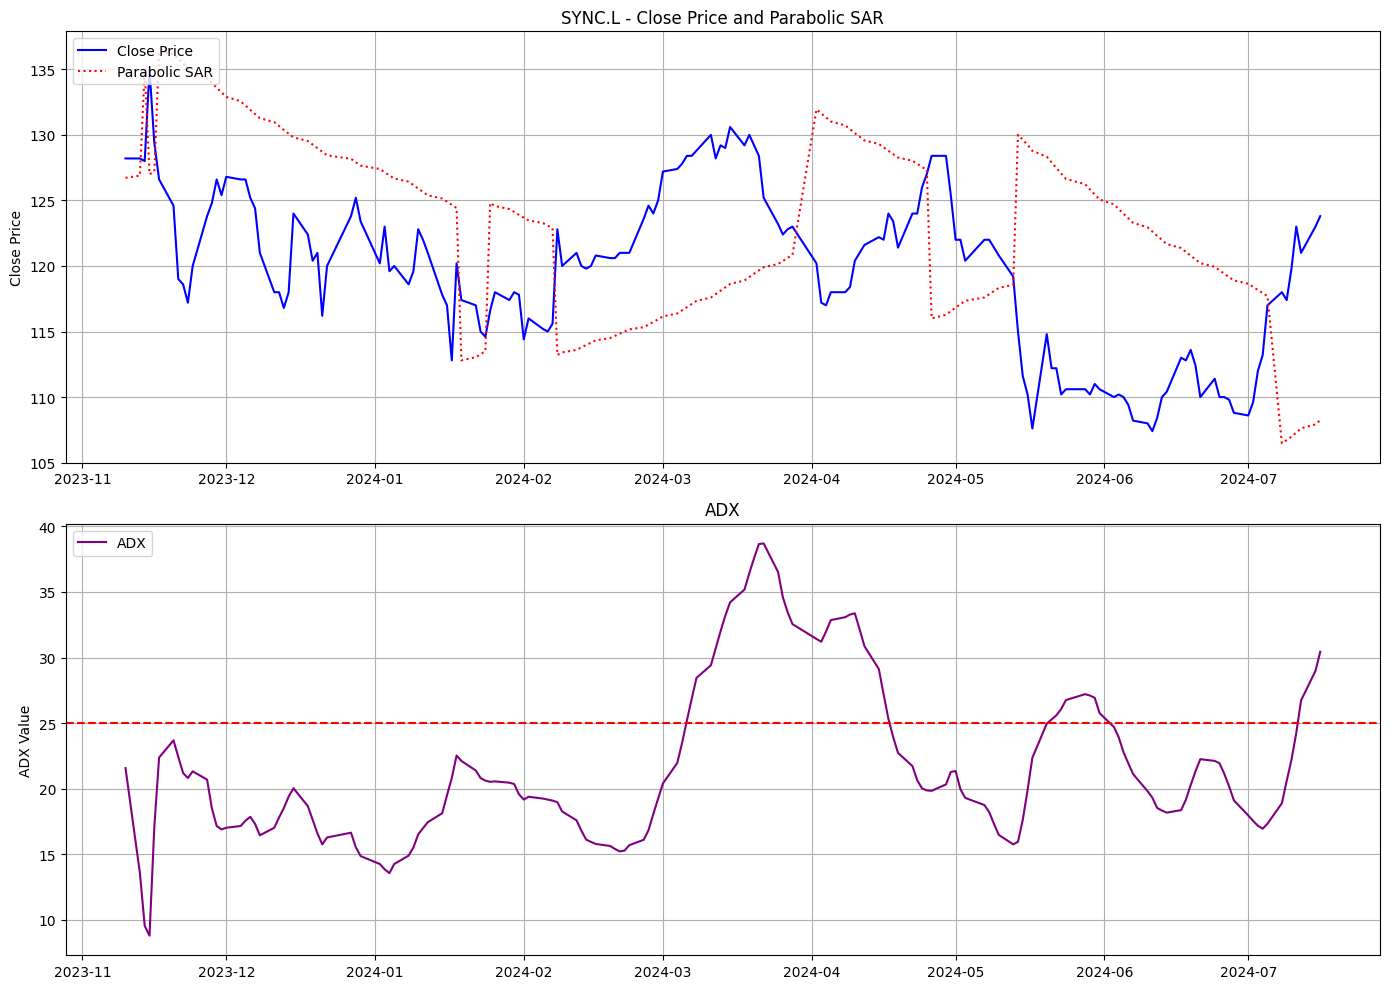

Ticker:                   SYNC.L
Company:                  SYNCONA LIMITED ORD NPV
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £803,205,184
Shares Outstanding:       644,627,008
52-Week High:             188.2
52-Week Low:              105.0
PE Ratio (TTM):           124.6
EPS (TTM):                0.01
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £30,749,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £3,788,000
Total Debt:               £0
Operating Cash Flow (TTM): £20,473,000
Free Cash Flow (TTM):     £-2,151,875

Description:              Syncona Limited is a fund specializes in investments in hedge, equity and long-term alternative investment funds across multiple asset classes. It manages private equity, debt, fixed income and alternative investments. The fund prefers to invest in healthcare and life sciences sector with focus on Cell therapy, gene therapy, 

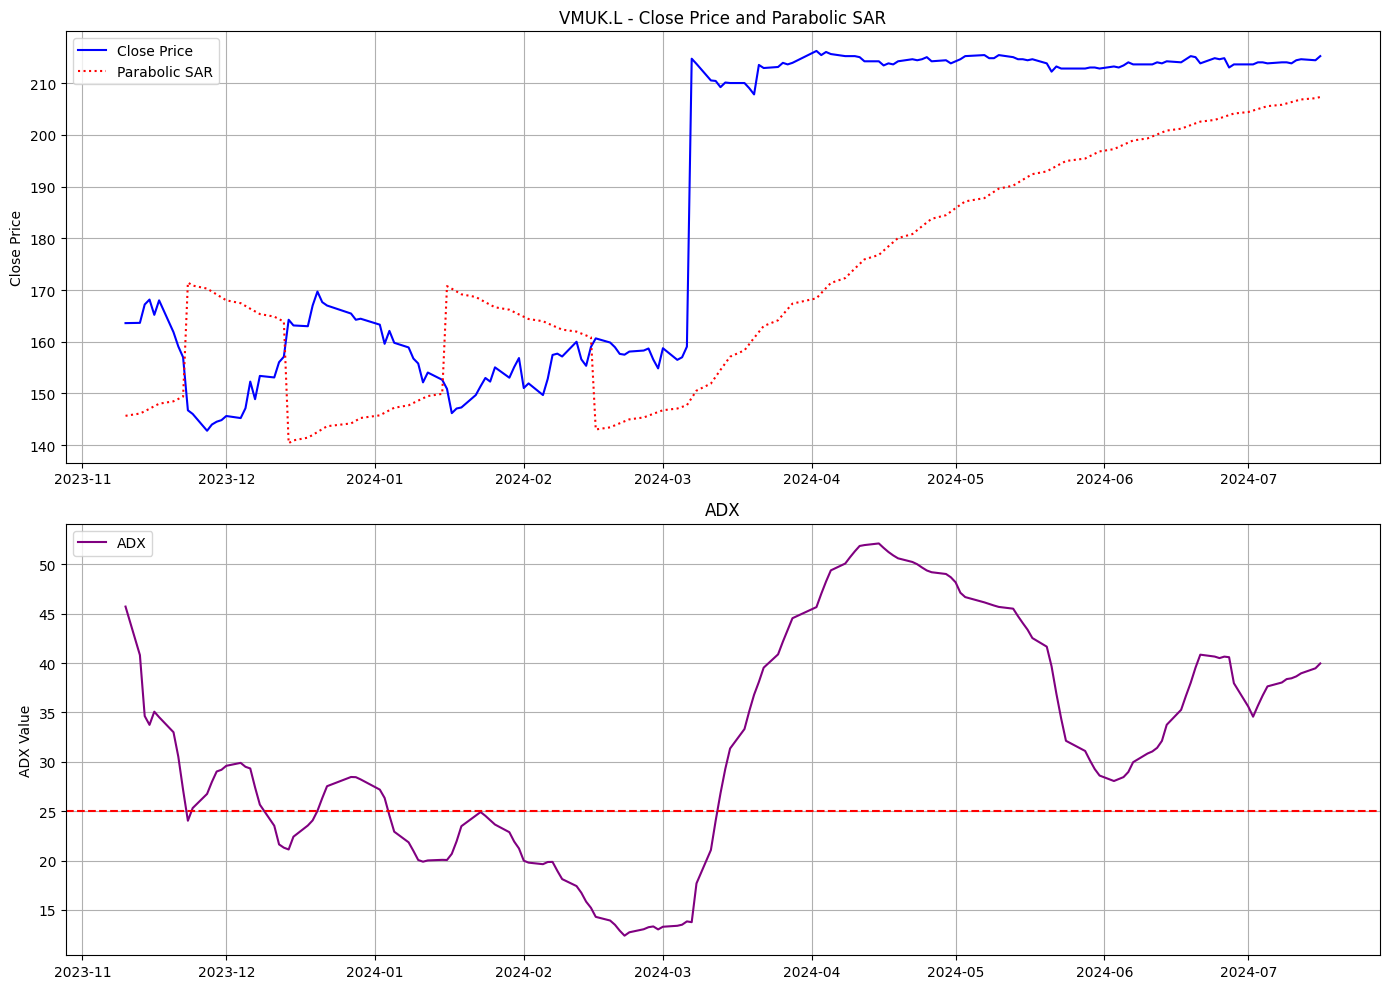

Ticker:                   VMUK.L
Company:                  VIRGIN MONEY UK PLC ORD GBP0.10
Sector:                   Financial Services
Industry:                 Banks - Regional
Market Cap:               £2,782,224,640
Shares Outstanding:       1,296,470,016
52-Week High:             219.0
52-Week Low:              140.4
PE Ratio (TTM):           9.330435
EPS (TTM):                0.23
Dividend Yield:           0.0186
Payout Ratio:             0.2333
Revenue (TTM):            £1,578,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £250,000,000
Total Debt:               £16,547,999,744
Operating Cash Flow (TTM): £1,065,000,000
Free Cash Flow (TTM):     N/A

Description:              Virgin Money UK PLC provides banking products and services for consumers, and small and medium sized businesses under the Clydesdale Bank, Yorkshire Bank, and Virgin Money brands in the United Kingdom. The company offers savings and current accounts, mortgages, credit cards, and home loans; b

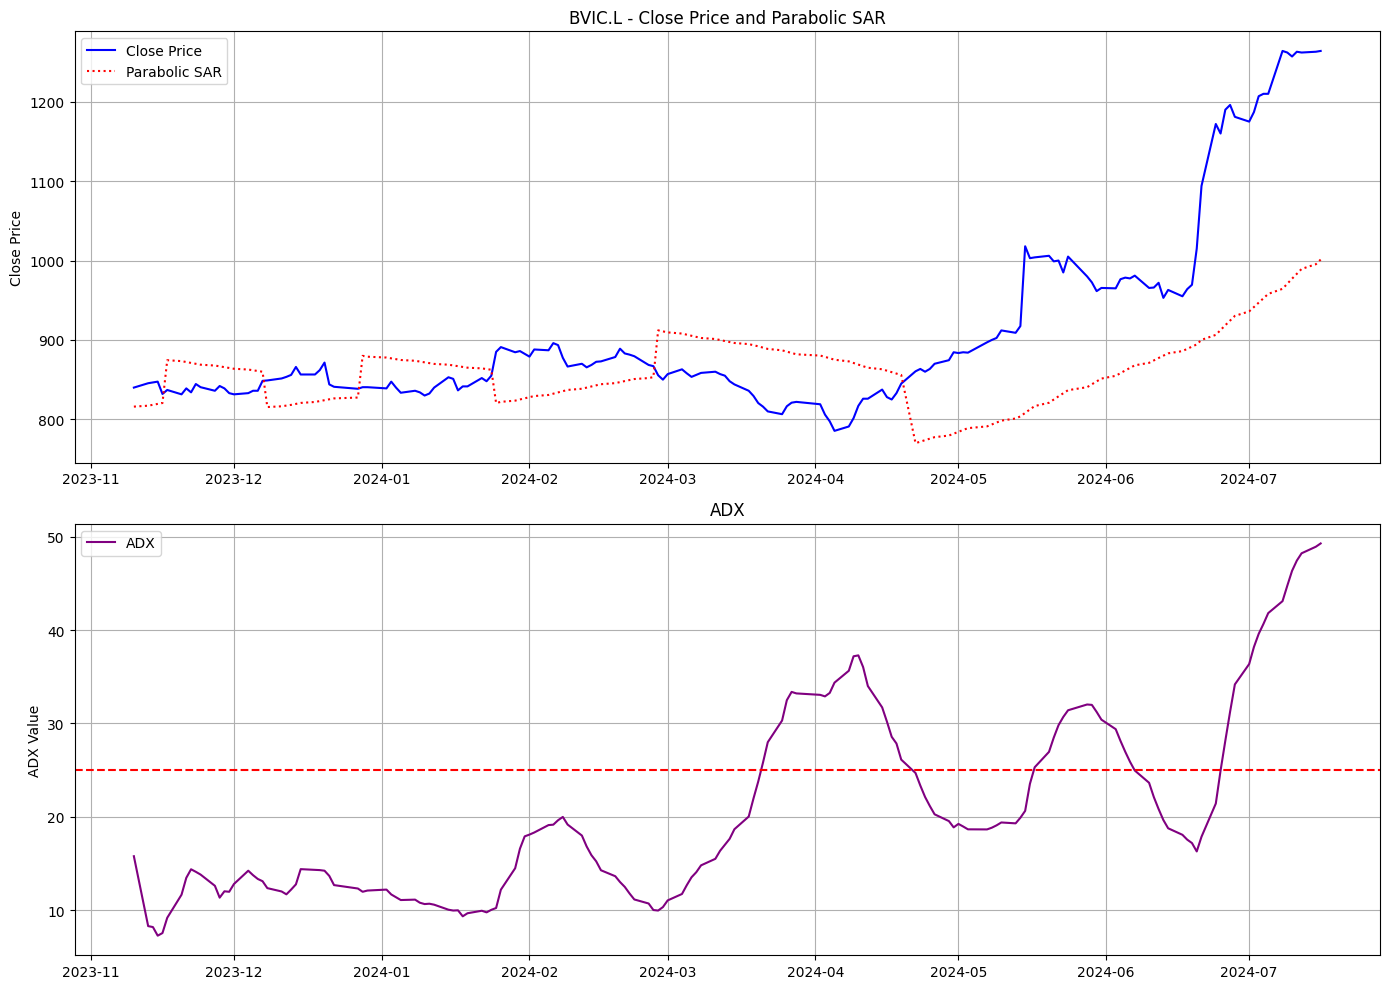

Ticker:                   BVIC.L
Company:                  BRITVIC PLC ORD 20P
Sector:                   Consumer Defensive
Industry:                 Beverages - Non-Alcoholic
Market Cap:               £3,118,755,584
Shares Outstanding:       246,736,992
52-Week High:             1287.0
52-Week Low:              770.0
PE Ratio (TTM):           24.784315
EPS (TTM):                0.51
Dividend Yield:           0.0254
Payout Ratio:             0.6051
Revenue (TTM):            £1,834,899,968
Gross Profit (TTM):       N/A
Net Income (TTM):         £129,500,000
Total Debt:               £812,400,000
Operating Cash Flow (TTM): £227,500,000
Free Cash Flow (TTM):     £87,762,496

Description:              Britvic plc, together with its subsidiaries, manufactures, markets, distributes, and sells soft drinks in the United Kingdom, the Republic of Ireland, France, Brazil, and internationally. It provides fruit juices, syrups, squash, mineral water, sodas, mixers, and energy and flavored drinks. T

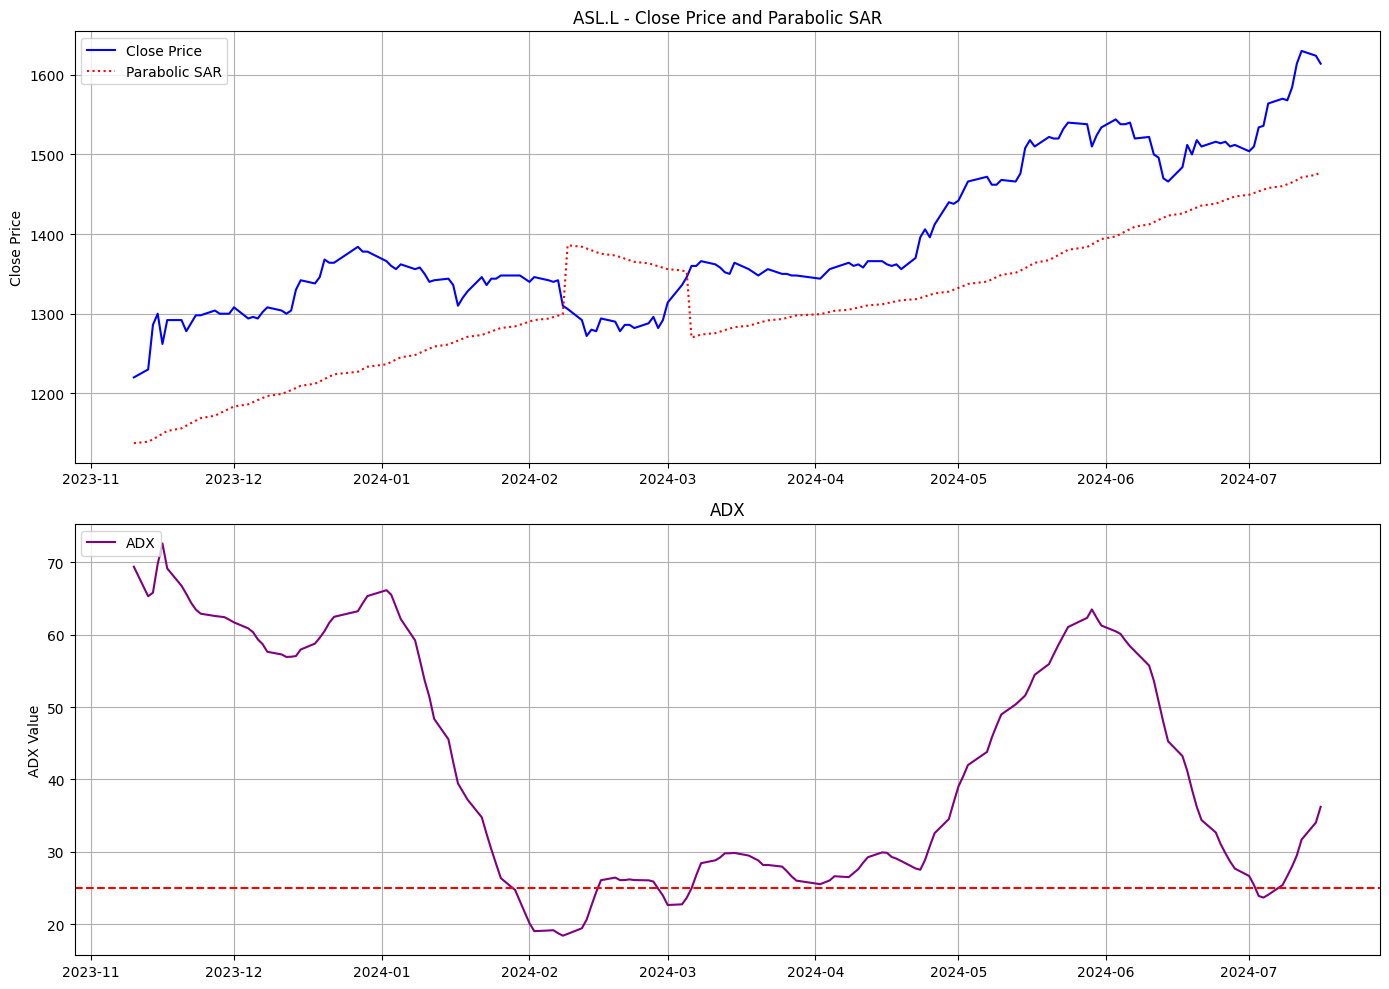

Ticker:                   ASL.L
Company:                  ABERFORTH SMALLER COMPANIES TRU
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,369,576,448
Shares Outstanding:       N/A
52-Week High:             1666.59
52-Week Low:              1126.0
PE Ratio (TTM):           13.9123335
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


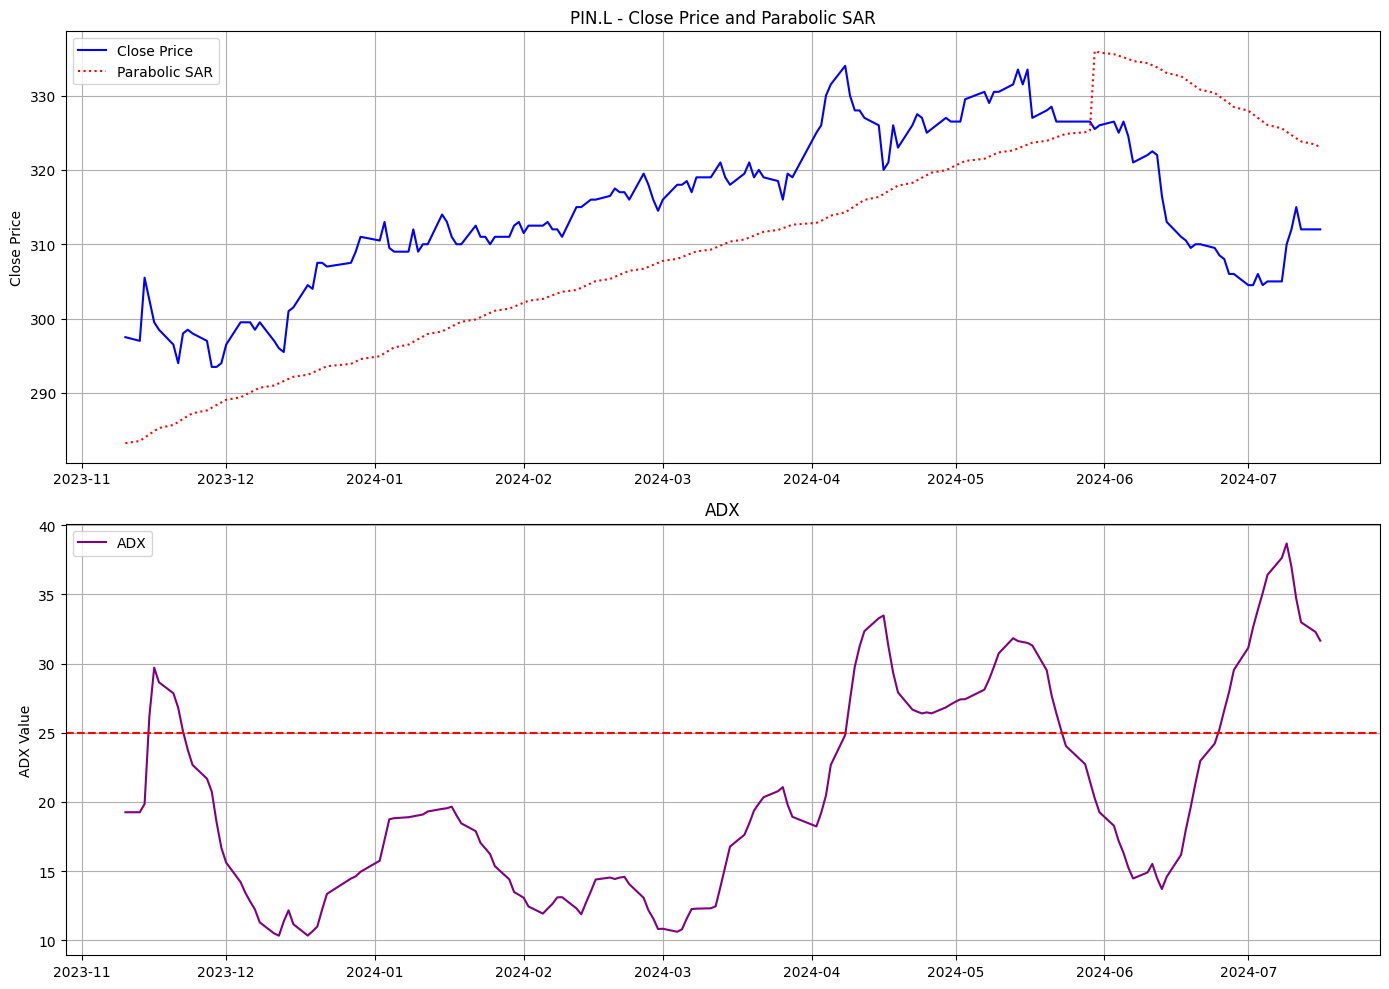

Ticker:                   PIN.L
Company:                  PANTHEON INTERNATIONAL PLC ORD 
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,440,015,104
Shares Outstanding:       N/A
52-Week High:             477.4
52-Week Low:              257.0
PE Ratio (TTM):           N/A
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


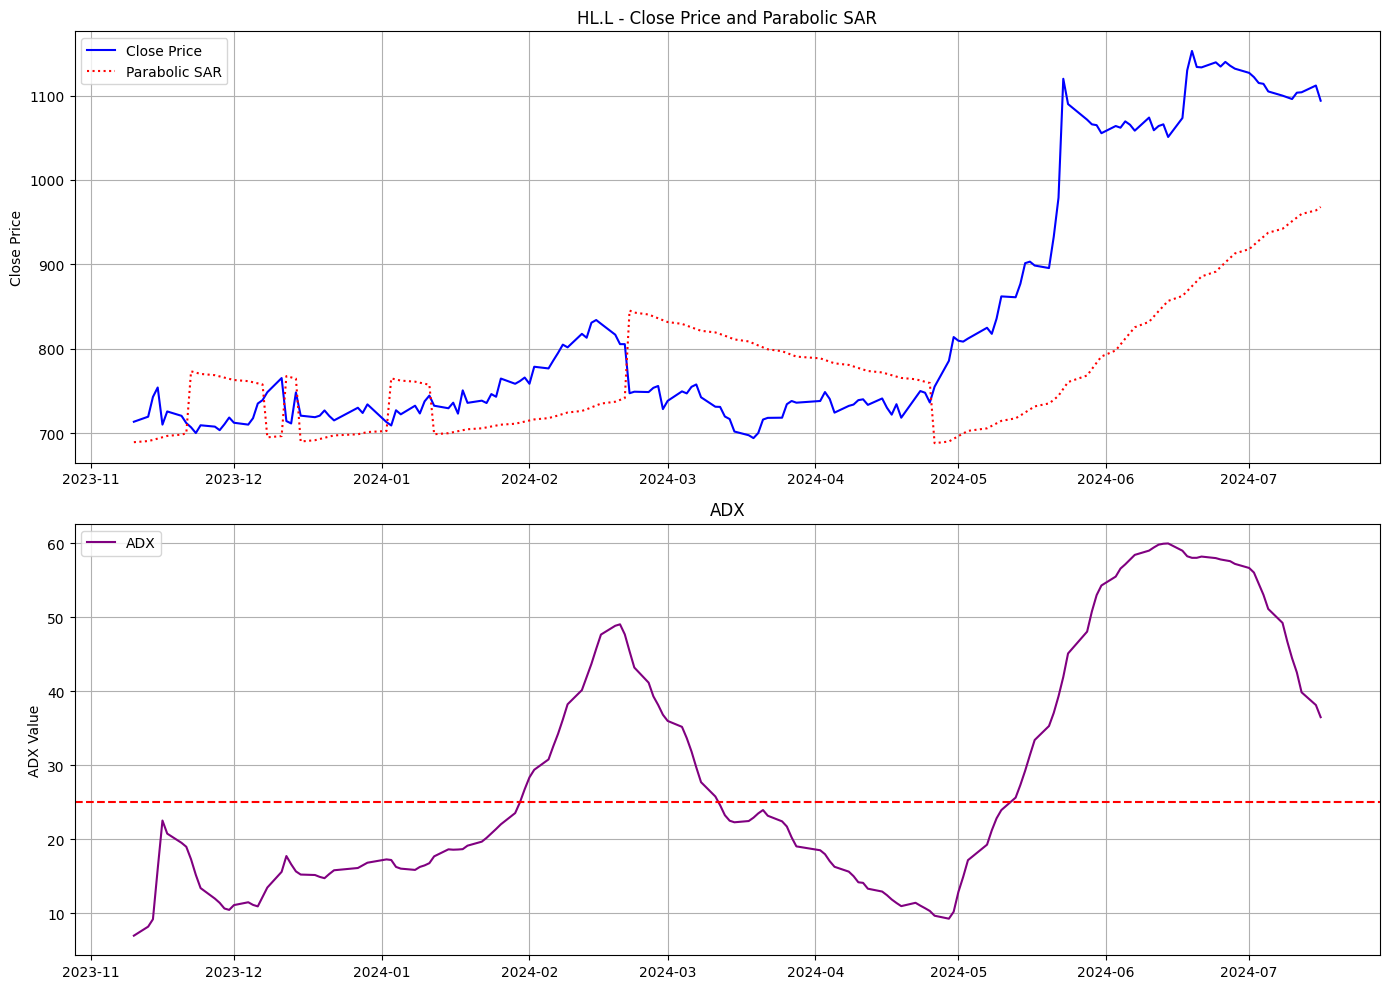

Ticker:                   HL.L
Company:                  HARGREAVES LANSDOWN PLC ORD 0.4
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £5,231,590,912
Shares Outstanding:       473,876,000
52-Week High:             1169.0
52-Week Low:              676.4
PE Ratio (TTM):           16.235294
EPS (TTM):                0.68
Dividend Yield:           0.0385
Payout Ratio:             0.5886
Revenue (TTM):            £753,299,968
Gross Profit (TTM):       N/A
Net Income (TTM):         £301,700,000
Total Debt:               £10,200,000
Operating Cash Flow (TTM): £318,100,000
Free Cash Flow (TTM):     £221,075,008

Description:              Hargreaves Lansdown plc provides investment services for individuals and corporates in the United Kingdom and Poland. The company offers stocks and shares individual savings accounts (ISAs), fund and share accounts, and junior and lifetime ISAs. It also provides pension services, including sel

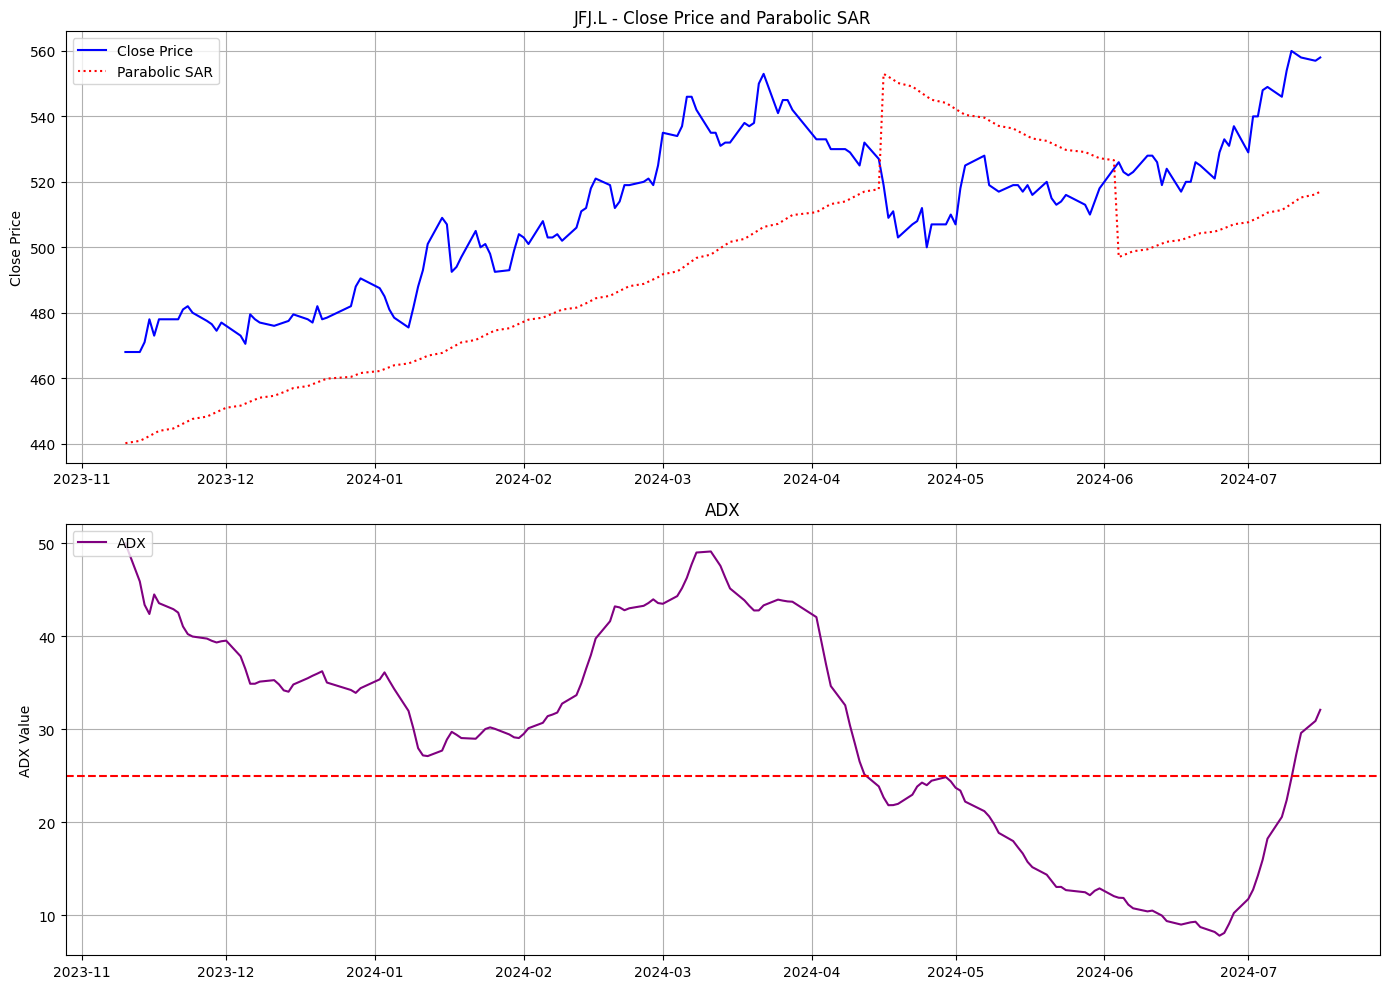

Ticker:                   JFJ.L
Company:                  JPMORGAN JAPANESE INVESTMENT TR
Sector:                   N/A
Industry:                 N/A
Market Cap:               £802,041,600
Shares Outstanding:       N/A
52-Week High:             584.82
52-Week Low:              435.0
PE Ratio (TTM):           6.166667
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


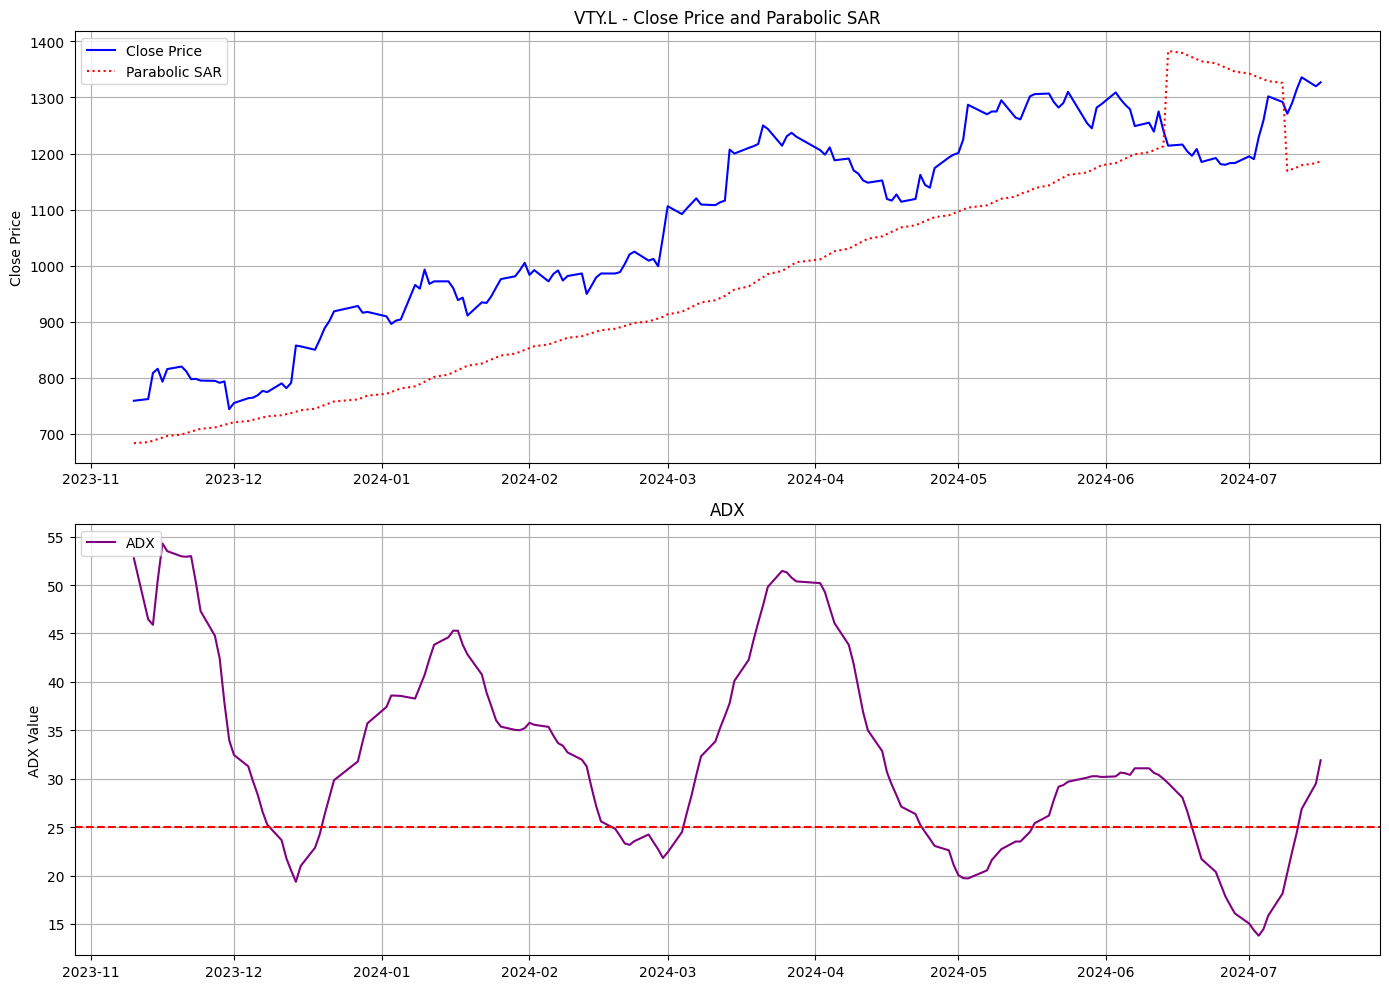

Ticker:                   VTY.L
Company:                  VISTRY GROUP PLC ORD 50P
Sector:                   Consumer Cyclical
Industry:                 Residential Construction
Market Cap:               £4,466,854,400
Shares Outstanding:       336,612,992
52-Week High:             1383.0
52-Week Low:              668.0
PE Ratio (TTM):           20.734377
EPS (TTM):                0.64
Dividend Yield:           N/A
Payout Ratio:             0.50240004
Revenue (TTM):            £3,564,199,936
Gross Profit (TTM):       N/A
Net Income (TTM):         £223,400,000
Total Debt:               £605,400,000
Operating Cash Flow (TTM): £-72,100,000
Free Cash Flow (TTM):     £-24,162,500

Description:              Vistry Group PLC, together with its subsidiaries, provides housing solutions in the United Kingdom. It offers o single family housing model. The company was formerly known as Bovis Homes Group PLC and changed its name to Vistry Group PLC in January 2020. Vistry Group PLC was founded in 18

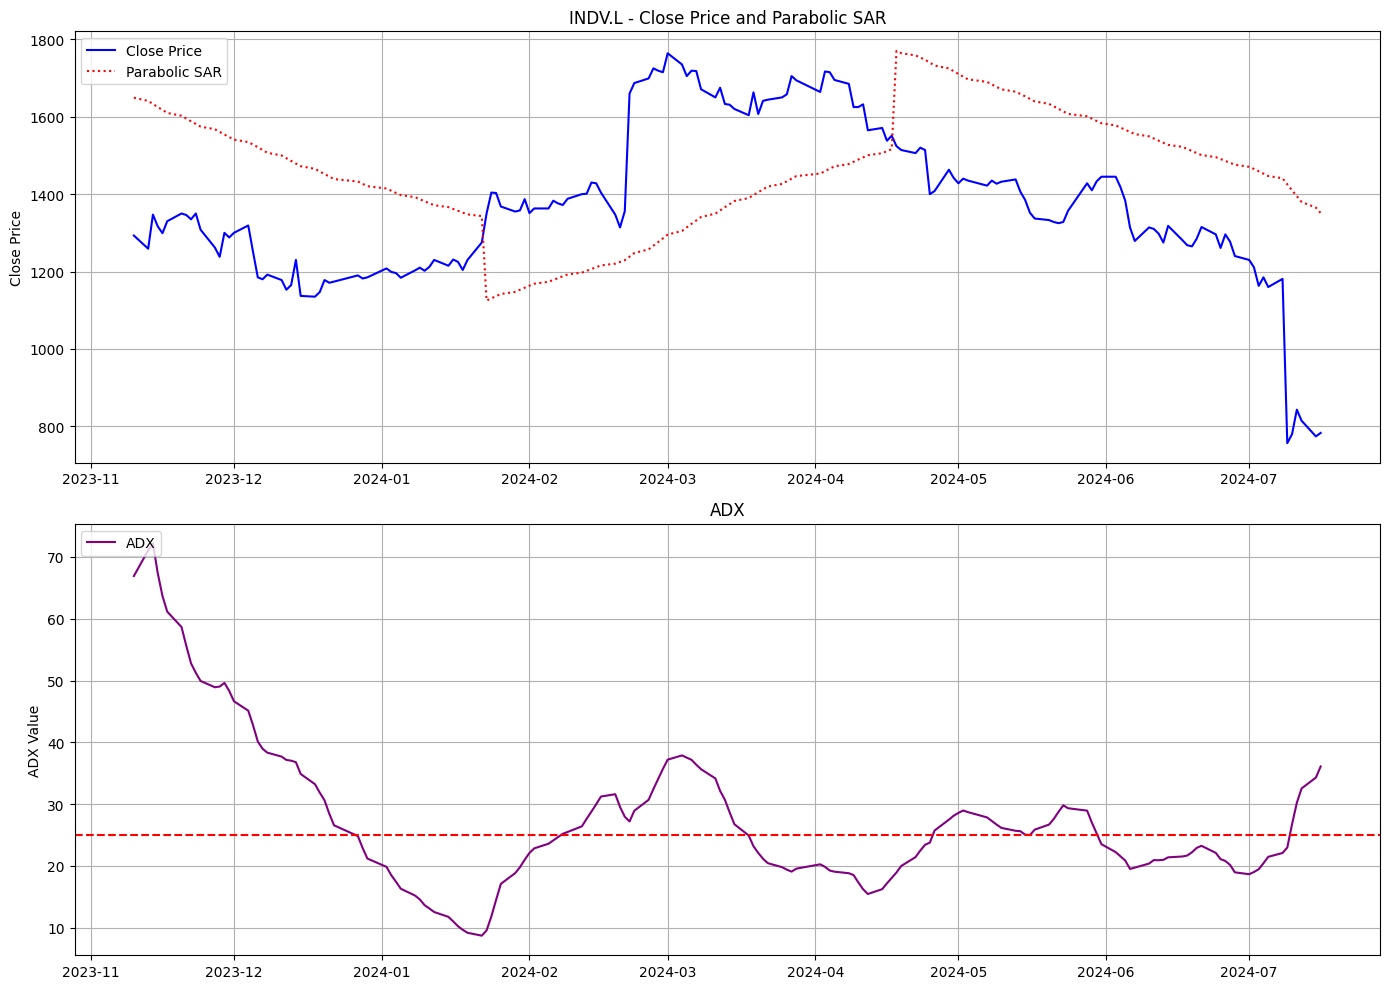

Ticker:                   INDV.L
Company:                  INDIVIOR PLC ORD USD0.50
Sector:                   Healthcare
Industry:                 Drug Manufacturers - Specialty & Generic
Market Cap:               £1,086,566,016
Shares Outstanding:       133,896,000
52-Week High:             1938.0
52-Week Low:              653.0
PE Ratio (TTM):           270.5
EPS (TTM):                0.03
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £1,124,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £5,000,000
Total Debt:               £279,000,000
Operating Cash Flow (TTM): £-334,000,000
Free Cash Flow (TTM):     £-87,375,000

Description:              Indivior PLC, together with its subsidiaries, engages in the development, manufacture, and sale of buprenorphine-based prescription drugs for the treatment of opioid dependence and co-occurring disorders in the United States, the United Kingdom, and internationally. The company develops med

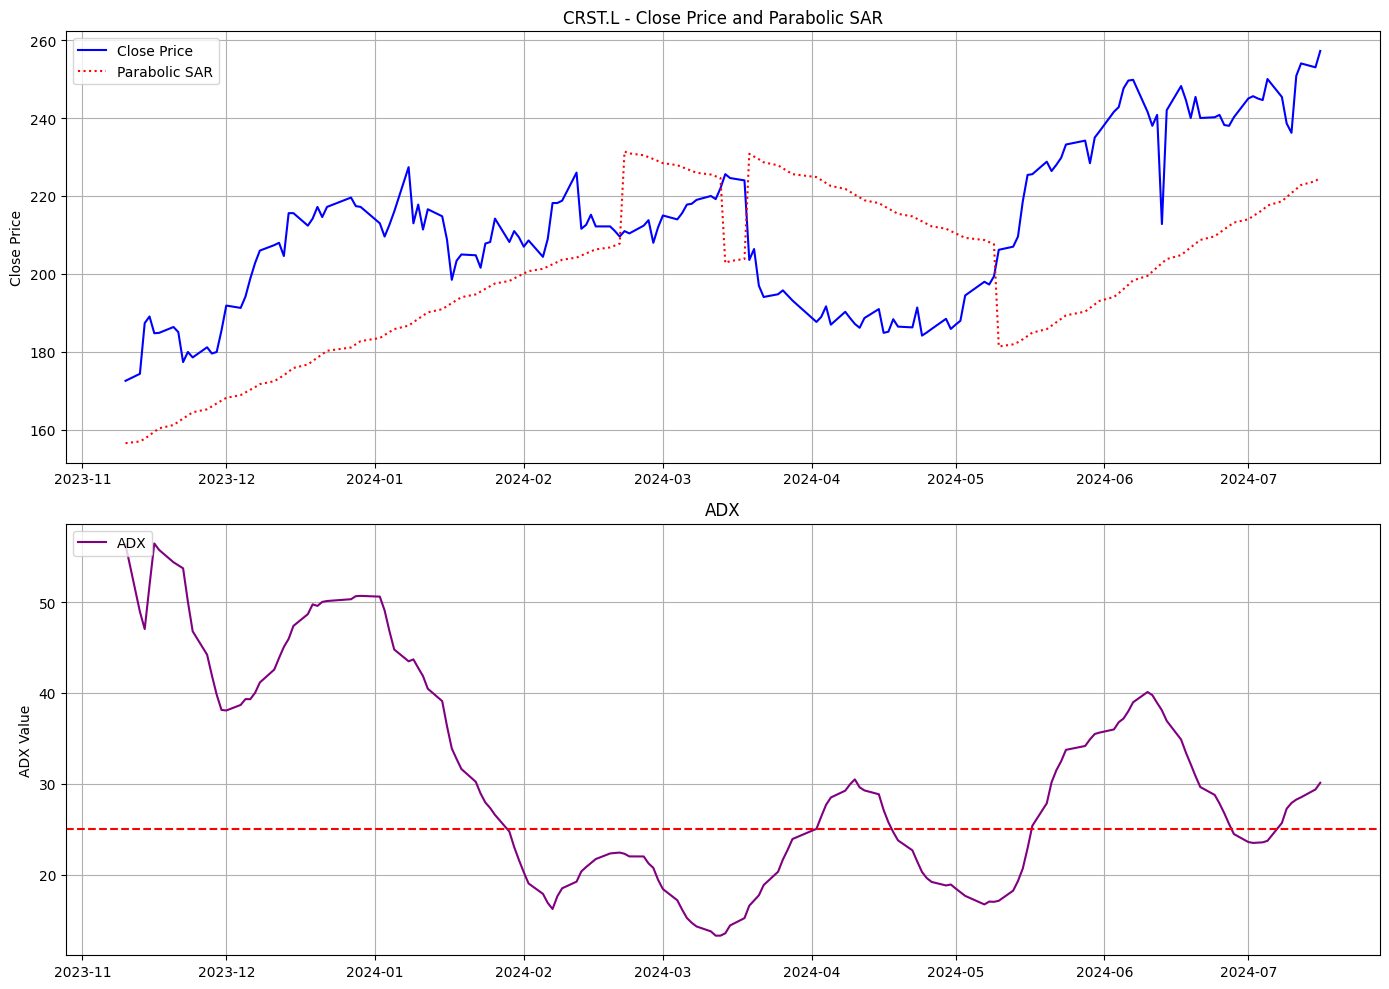

Ticker:                   CRST.L
Company:                  CREST NICHOLSON HOLDINGS PLC OR
Sector:                   Consumer Cyclical
Industry:                 Residential Construction
Market Cap:               £655,153,920
Shares Outstanding:       256,320,000
52-Week High:             272.4
52-Week Low:              152.7
PE Ratio (TTM):           N/A
EPS (TTM):                -0.1
Dividend Yield:           0.0493
Payout Ratio:             2.4286
Revenue (TTM):            £632,300,032
Gross Profit (TTM):       N/A
Net Income (TTM):         £-26,600,000
Total Debt:               £105,400,000
Operating Cash Flow (TTM): £-51,100,000
Free Cash Flow (TTM):     £-25,887,500

Description:              Crest Nicholson Holdings plc engages in building residential homes in the United Kingdom. It develops and sells apartments, houses, and commercial properties. The company was founded in 1963 and is headquartered in Addlestone, the United Kingdom.
----------------------------------------------

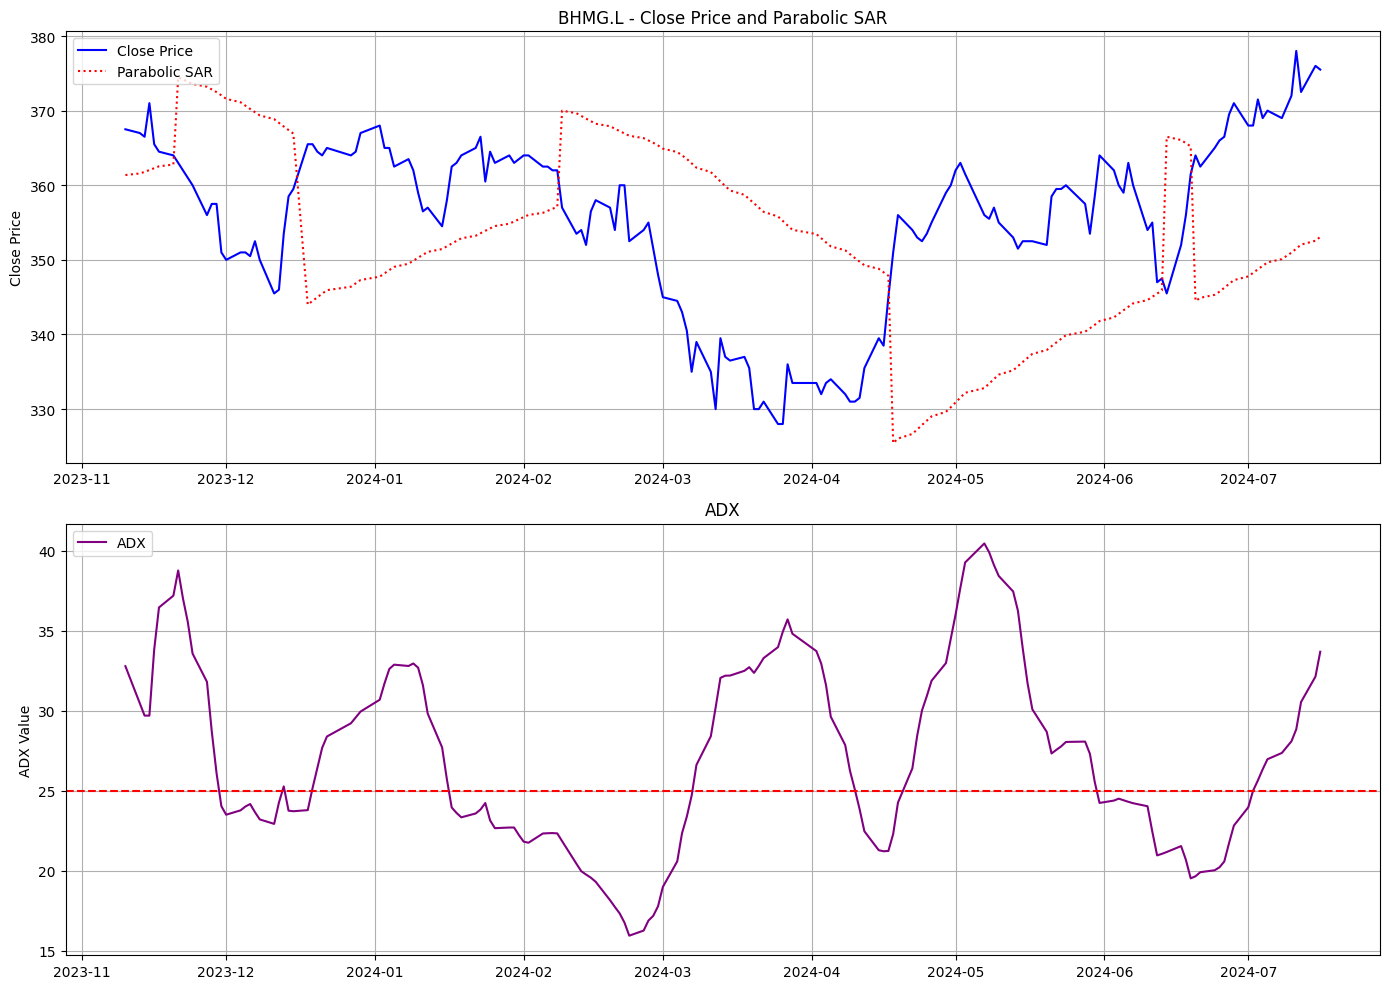

Ticker:                   BHMG.L
Company:                  BH MACRO LIMITED ORD NPV (GBP)
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £1,412,035,584
Shares Outstanding:       356,545,984
52-Week High:             410.0
52-Week Low:              325.434
PE Ratio (TTM):           24.739998
EPS (TTM):                0.15
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £14,124,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £66,494,000
Total Debt:               £0
Operating Cash Flow (TTM): £-357,639,008
Free Cash Flow (TTM):     £-24,702,876

Description:              BH Macro Limited is a feeder fund launched and managed by Brevan Howard Asset Management LLP. It invests its entire corpus in the Brevan Howard Master Fund Limited. BH Macro Limited was formed on January 17, 2007 and is domiciled in Guernsey, Channel Islands.
------------------------------------------------

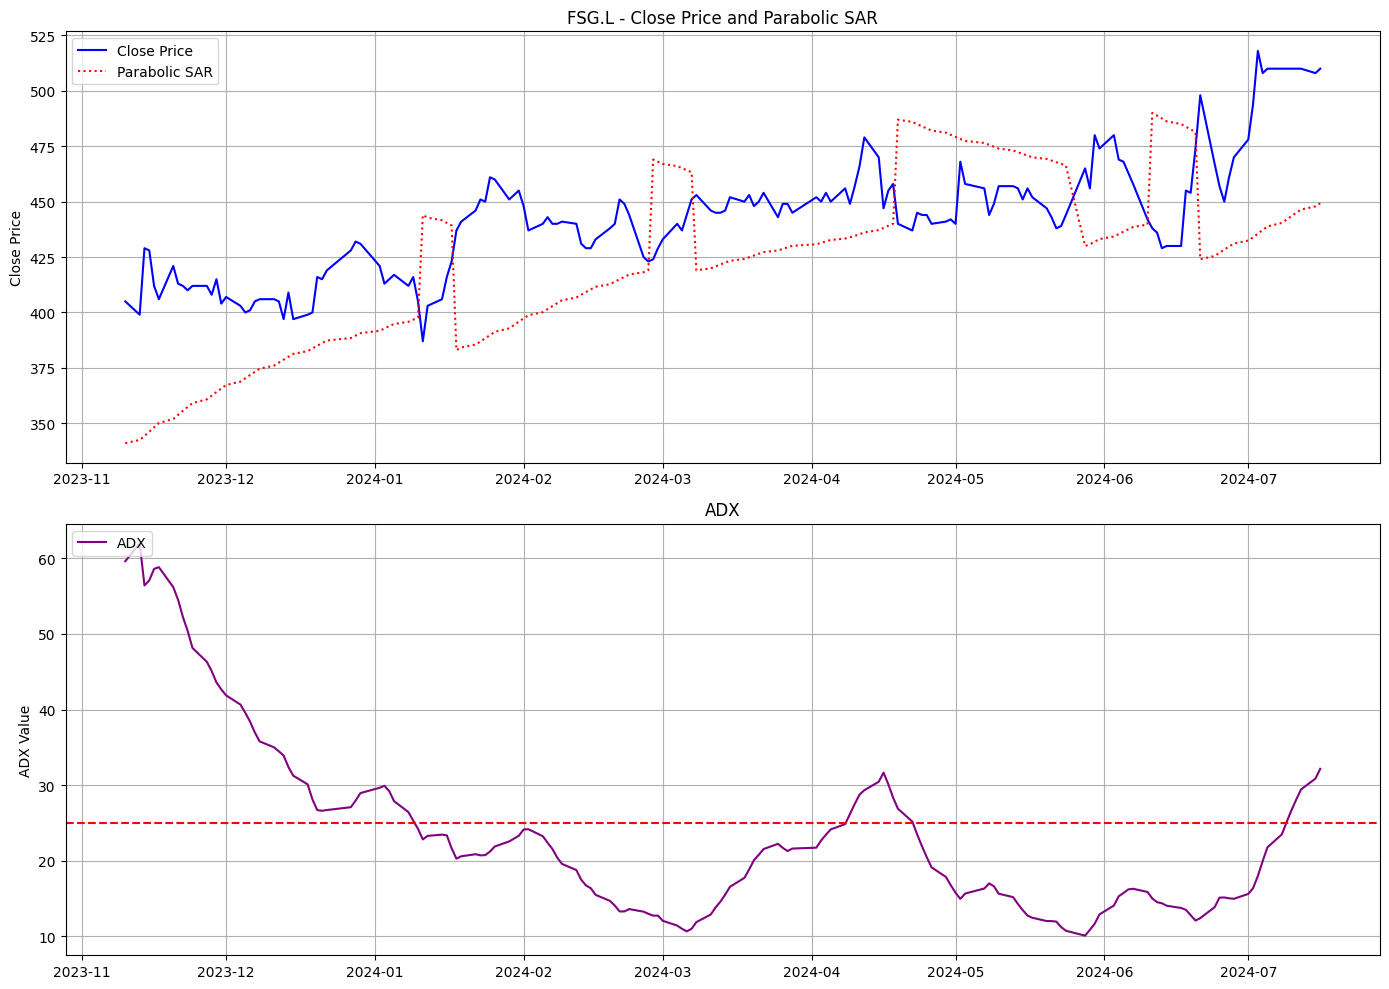

Ticker:                   FSG.L
Company:                  FORESIGHT GROUP HOLDINGS LIMITE
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £582,160,320
Shares Outstanding:       115,508,000
52-Week High:             518.0
52-Week Low:              330.0
PE Ratio (TTM):           22.90909
EPS (TTM):                0.22
Dividend Yield:           0.0608
Payout Ratio:             1.0
Revenue (TTM):            £141,326,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £26,434,000
Total Debt:               £7,771,000
Operating Cash Flow (TTM): £44,674,000
Free Cash Flow (TTM):     £35,590,752

Description:              Foresight Group Holdings Limited operates as an infrastructure and private equity manager in the United Kingdom, Italy, Luxembourg, Ireland, Spain, and Australia. It operates through Infrastructure, Private Equity, and Foresight Capital Management segments. The company involved in the provision of the m

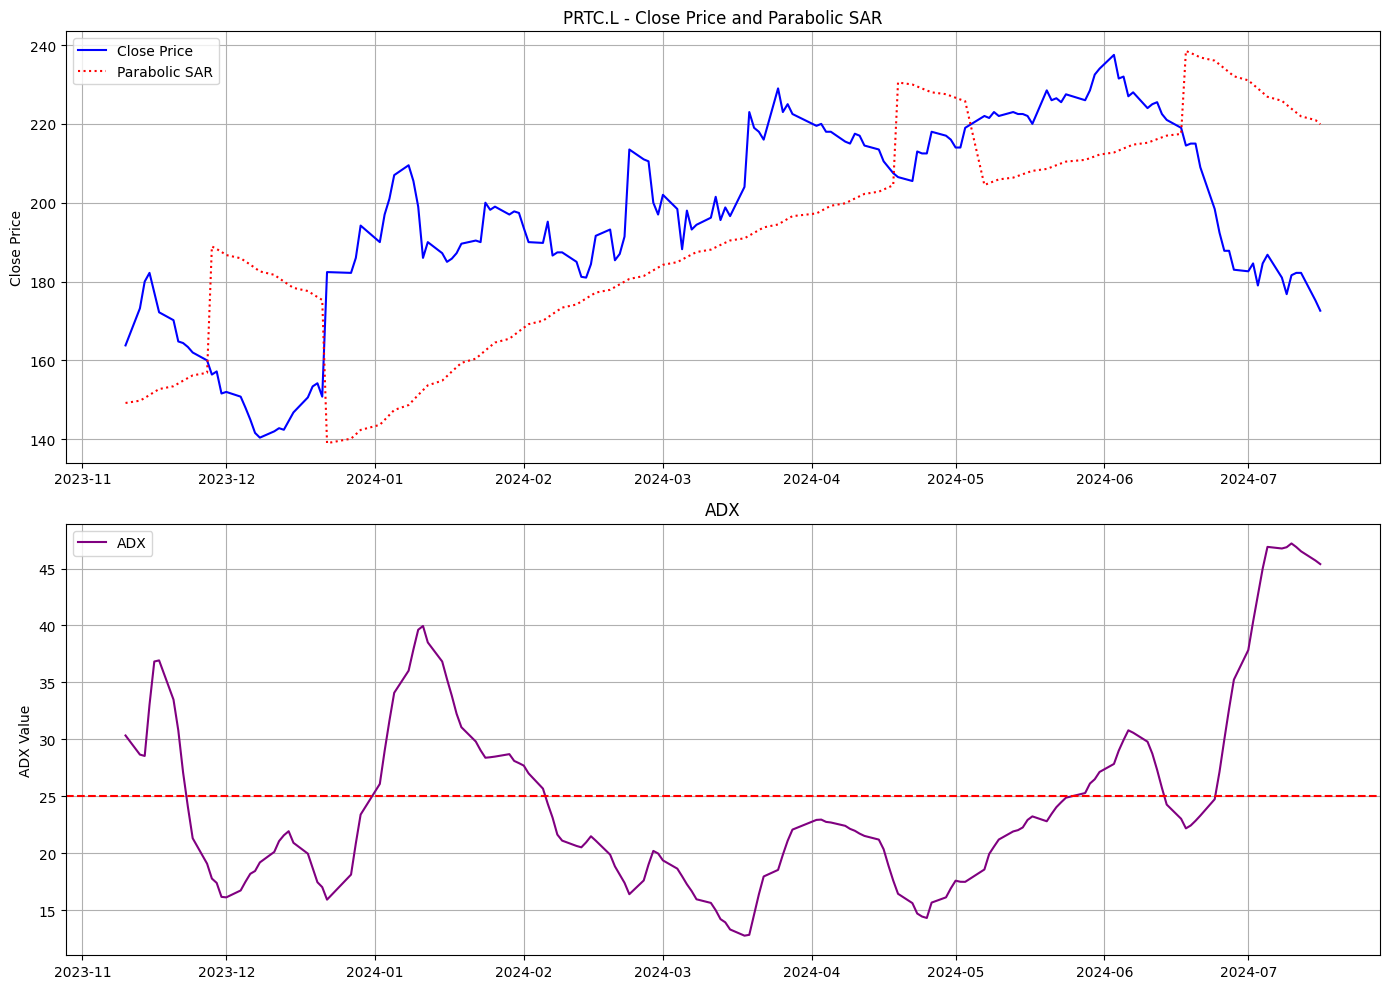

Ticker:                   PRTC.L
Company:                  PURETECH HEALTH PLC ORD 1P
Sector:                   Healthcare
Industry:                 Biotechnology
Market Cap:               £409,424,064
Shares Outstanding:       239,319,008
52-Week High:             238.5
52-Week Low:              139.0
PE Ratio (TTM):           N/A
EPS (TTM):                -0.18
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £3,330,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £-65,697,000
Total Debt:               £135,502,000
Operating Cash Flow (TTM): £-105,917,000
Free Cash Flow (TTM):     £-114,798,000

Description:              PureTech Health plc, engages in the development and commercialization of biotechnology and pharmaceutical solutions in the United States. The company is developing LYT-100, which is under Phase 2 stage, to treat idiopathic pulmonary fibrosis (IPF); and LYT-200, a IgG4 monoclonal antibody, currently under Phase 1/2 stage

In [9]:
# Function to plot ADX and SAR indicators

# Function to print basic financial data
def print_financial_data(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    def format_value(value, currency=False):
        if isinstance(value, (int, float)):
            formatted_value = f"{value:,}"
            if currency:
                formatted_value = f"£{formatted_value}"
            return formatted_value
        return value

    market_cap = format_value(info.get('marketCap', 'N/A'), currency=True)
    shares_outstanding = format_value(info.get('sharesOutstanding', 'N/A'))
    year_high = info.get('fiftyTwoWeekHigh', 'N/A')
    year_low = info.get('fiftyTwoWeekLow', 'N/A')
    pe_ratio = info.get('trailingPE', 'N/A')
    eps = info.get('trailingEps', 'N/A')
    dividend_yield = info.get('dividendYield', 'N/A')
    payout_ratio = info.get('payoutRatio', 'N/A')
    revenue = format_value(info.get('totalRevenue', 'N/A'), currency=True)
    gross_profit = format_value(info.get('grossProfits', 'N/A'), currency=True)
    net_income = format_value(info.get('netIncomeToCommon', 'N/A'), currency=True)
    total_debt = format_value(info.get('totalDebt', 'N/A'), currency=True)
    operating_cash_flow = format_value(info.get('operatingCashflow', 'N/A'), currency=True)
    free_cash_flow = format_value(info.get('freeCashflow', 'N/A'), currency=True)
    sector = info.get('sector', 'N/A')
    industry = info.get('industry', 'N/A')
    description = info.get('longBusinessSummary', 'N/A')

    print(f"{'Ticker:':<25} {ticker}")
    print(f"{'Company:':<25} {info.get('shortName', 'N/A')}")
    print(f"{'Sector:':<25} {sector}")
    print(f"{'Industry:':<25} {industry}")
    print(f"{'Market Cap:':<25} {market_cap}")
    print(f"{'Shares Outstanding:':<25} {shares_outstanding}")
    print(f"{'52-Week High:':<25} {year_high}")
    print(f"{'52-Week Low:':<25} {year_low}")
    print(f"{'PE Ratio (TTM):':<25} {pe_ratio}")
    print(f"{'EPS (TTM):':<25} {eps}")
    print(f"{'Dividend Yield:':<25} {dividend_yield}")
    print(f"{'Payout Ratio:':<25} {payout_ratio}")
    print(f"{'Revenue (TTM):':<25} {revenue}")
    print(f"{'Gross Profit (TTM):':<25} {gross_profit}")
    print(f"{'Net Income (TTM):':<25} {net_income}")
    print(f"{'Total Debt:':<25} {total_debt}")
    print(f"{'Operating Cash Flow (TTM):':<25} {operating_cash_flow}")
    print(f"{'Free Cash Flow (TTM):':<25} {free_cash_flow}")
    print(f"\n{'Description:':<25} {description}")  # Print the full description
    print("-" * 50)



def plot_adx_sar(data, symbol):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Plot Close Price and SAR
    ax1.plot(data.index, data['Close'], label='Close Price', color='blue')
    ax1.plot(data.index, data['SAR'], label='Parabolic SAR', color='red', linestyle='dotted')
    ax1.set_title(f'{symbol} - Close Price and Parabolic SAR')
    ax1.set_ylabel('Close Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot ADX
    ax2.plot(data.index, data['ADX'], label='ADX', color='purple')
    ax2.axhline(25, color='red', linestyle='--')
    ax2.set_title('ADX')
    ax2.set_ylabel('ADX Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Print the introductory text
print("The following stocks have met the specified criteria. A plot is displayed showing the stock price and its relationship to the associated indicators. Additionally, detailed financial and company information is provided for each stock.\n")



# Iterate through all tickers to plot graphs and print financial data
for stock_data in results:
    symbol = stock_data["Symbol"]
    data = stock_data["Data"]
    plot_adx_sar(data, symbol)
    print_financial_data(symbol)
    
